In [11]:
import matplotlib.pyplot as plt
import numpy as np

from sciopy import EIT_16_32_64_128, EitMeasurementSetup
import matplotlib.pyplot as plt

In [12]:
# create a 'sciospec' class which represents the sciospec EIT device
n_el =  64
#64 
sciospec = EIT_16_32_64_128(n_el)

In [13]:
# connect device via USB-HS port
sciospec.connect_device_HS()

In [14]:
# read system message buffer
sciospec.SystemMessageCallback()
# should be empty

No message inside the message buffer
message buffer:
 []
message length:	 0


In [15]:
# create a measurement setup
setup = EitMeasurementSetup(
    burst_count=5,
    n_el=n_el,
    exc_freq=125_000,
    framerate=3,
    amplitude=0.01,
    inj_skip=n_el // 2,
    gain=1,
    adc_range=1,
)

In [16]:
sciospec.SetMeasurementSetup(setup)

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4


In [20]:
# get data
data = sciospec.StartStopMeasurement(return_as="pot_mat")  # or "hex"  # kommt in for schleife 

In [21]:
data.shape   #mitteln, 1-4 burst count für training, und 5. für test for pot in data:

(5, 64, 64)

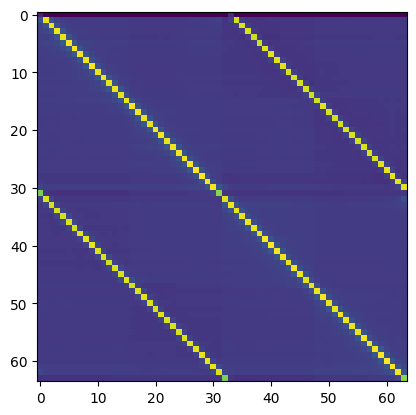

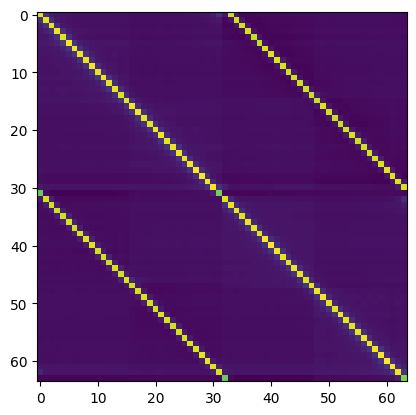

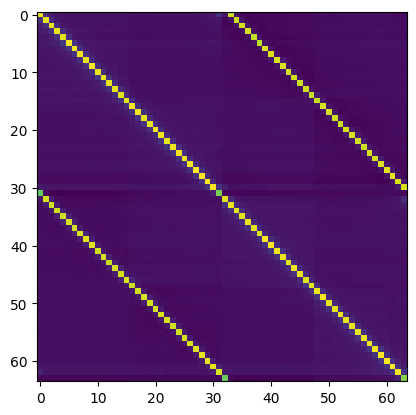

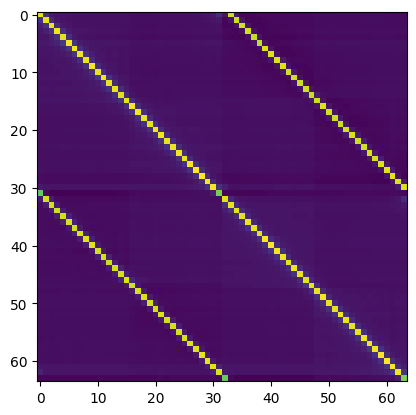

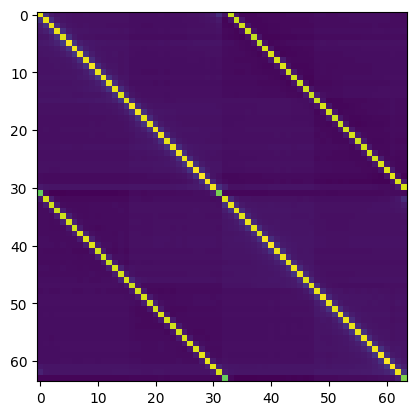

In [22]:
for pot in data:
    plt.imshow(np.abs(pot))
    plt.show()

In [23]:
import serial

from typing import Union
import time
from datetime import datetime
import numpy as np
import sys
import glob
from src.util import (
    create_trajectory,
    create_trajectory_3D
)
import os
from glob import glob
from tqdm import tqdm
# https://reprap.org/wiki/G-code#M17:_Enable.2FPower_all_stepper_motors

def command(ser, command) -> None:
    ser.write(str.encode(command))
    time.sleep(1)
    while True:
        line = ser.readline()
        print(line)

        if line == b"ok\n":
            break

# class
class EnderControl:
    def __init__(self,com_port, baudrate = 115200, timeout = 1, motion_speed = 1000):
        self.com_port = com_port
        self.baudrate = baudrate
        self.motion_speed = motion_speed # movement in mm/min
        self.position_timestamps = []  # Hier wird das Attribut position_timestamps korrekt initialisiert


    def connect(self):
        com = serial.Serial(
            port=self.com_port,
            baudrate=self.baudrate,
            parity=serial.PARITY_NONE,
            stopbits=serial.STOPBITS_ONE,
            bytesize=serial.EIGHTBITS,
        )
    
        print("Connection to", com.name, "is established.")
        self.com = com
        
    def init(self):
        """
        Initialise the axis
        """
        # x_y_home(ser)
        command(self.com, f"G28 X0 Y0 F{self.motion_speed}\r\n")
        command(self.com, f"G28 Z0 F{self.motion_speed}\r\n")
        self.x_y_center()
        self.turn_off_fan()
        print("X,Y axis are centered at X(180), Y(180)")

        return [180, 180]
    
    def turn_off_fan(self):
        command(self.com, "M106 S0\r\n")

    def x_y_center(self):
        command(self.com, f"G0 X180 Y180 F{self.motion_speed}\r\n")

    def move_to_absolute_x_y(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180]
        return pos

    def move_to_absolute_x_y_z(self, P) -> None:
        command(
            self.com,
            f"G0 X{P[0]+180} Y{P[1]+180} Z{P[2]} F{self.motion_speed}\r\n",
        )
        pos = [P[0]+180, P[1]+180, P[2]]  #z im Bereich 50 bis 100 mm
        return pos

    def read_temperature(self) -> float:
        """
        Read the bed temperature of the Ender 5.
    
        This function sends the M105 command, which requests the current temperature.
    
        Returns
        -------
        float
            The bed temperature value.
        """
    
        self.com.write(str.encode(f"M105\r\n"))
        time.sleep(1)
        line = self.com.readline()
        temp = float(str(line).split("B:")[1].split(" ")[0])
        
        return temp

    def get_timestamp(self) -> str:
        """
        Returns the current timestamp in the format YYYY-MM-DD HH:MM:SS
        """
        current_time = datetime.now()  # Get the current date and time
        formatted_timestamp = current_time.strftime("%Y-%m-%d %H:%M:%S")  # Format the timestamp
        return current_time, formatted_timestamp

In [24]:
printer = EnderControl(com_port="/dev/ttyUSB0")
printer.connect()

Connection to /dev/ttyUSB0 is established.


## Initializing Printer ##

In [25]:
printer.init()

b'start\n'
b'echo: External Reset\n'
b'Marlin Ver 1.70.3 BL\n'
b'\n'
b'echo: Last Updated: 2022-02-24 | Author: Ender-5 Plus\n'
b'echo:Compiled: Feb 24 2022\n'
b'echo: Free Memory: 1406  PlannerBufferBytes: 1232\n'
b'echo:V42 stored settings retrieved (530 bytes; crc 12996)\n'
b'echo:  G21    ; Units in mm\n'
b'echo:  M149 C ; Units in Celsius\n'
b'\n'
b'echo:Filament settings: Disabled\n'
b'echo:  M200 D1.75\n'
b'echo:  M200 D0\n'
b'echo:Steps per unit:\n'
b'echo:  M92 X80.00 Y80.00 Z800.00 E92.60\n'
b'echo:Maximum feedrates (units/s):\n'
b'echo:  M203 X300.00 Y300.00 Z5.00 E25.00\n'
b'echo:Maximum Acceleration (units/s2):\n'
b'echo:  M201 X500 Y500 Z100 E1000\n'
b'echo:Acceleration (units/s2): P<print_accel> R<retract_accel> T<travel_accel>\n'
b'echo:  M204 P500.00 R500.00 T1000.00\n'
b'echo:Advanced: S<min_feedrate> T<min_travel_feedrate> B<min_segment_time_ms> X<max_xy_jerk> Z<max_z_jerk> E<max_e_jerk>\n'
b'echo:  M205 S0.00 T0.00 B20000 X10.00 Y10.00 Z0.40 E5.00\n'
b'echo:Home off

[180, 180]

## Generating and saving data ##

In [26]:
def generate_exp_data(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=750):

    #ref_radius = 0.2
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    #center_pos = create_trajectory(traj, r_path * 97, scaled_points)  # Trajektorie mit der skalierten Punktzahl
    center_pos = create_trajectory(traj, r_path * 97, base_points)
    base_dataset_folder = "exp_data_set"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": base_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz")
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")


def generate_exp_data_3D(traj, r_path, r_anomaly, material, empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=1000):
    #ref_radius = 0.5
    #scale_factor = r_path / ref_radius
    #scaled_points = int(round(base_points * scale_factor))
    #print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
    fig = plt.figure(figsize=(20, 8))

    n_turns = 3
    
    center_pos = create_trajectory_3D(traj, r_path*97, base_points, n_turns)
    #print(center_pos)
    
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax1.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax1.view_init(elev=90, azim=0)  # Top view
    ax1.set_title('Top View')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax2.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax2.view_init(elev=0, azim=0)  # Side view
    ax2.set_title('Side View')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.plot(center_pos[:,0], center_pos[:,1], center_pos[:,2], color='red', label='Trajectory')
    ax3.scatter(center_pos[:, 0], center_pos[:, 1], center_pos[:, 2], color='blue', marker='o', s=1, label='Points')
    ax3.view_init(elev=45, azim=45)  # Isometric view
    ax3.set_title('Isometric View')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')

    plt.tight_layout()
    for ax in [ax1, ax2, ax3]:
        ax.legend()
    
    plt.show()

    base_dataset_folder = "exp_data_set_3D"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data_3D"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Trajectory": traj,
        "Nsteps": base_points,
        "r_anomaly": r_anomaly,
        "r_path": r_path,
        "material": material,
    }

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_3D_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    empty_tank_pos = [180, 180, 00]
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)
    
    for save_index, Ps in tqdm(enumerate(center_pos), total=len(center_pos)): 
        pos = printer.move_to_absolute_x_y_z(Ps)  
        temp = printer.read_temperature()  
        machine_time, timestamp = printer.get_timestamp()  
        data = sciospec.StartStopMeasurement(return_as="pot_mat")  
        
        file_path = os.path.join(folder_name, f"sample_{save_index + 1:06d}.npz") 
        np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                 temperature=temp, v=data)

    print("Measurement is complete!")



import time  

def generate_exp_data_sequential_multiple_trajs(traj_list, r_path_list, r_anomaly_list, material, empty_tank_pos, empty_tank_timestamp, 
                                                 empty_tank_machine_time, empty_tank_temp, empty_tank_data, base_points=50, 
                                                 resume=False):
    fig = plt.figure(figsize=(20, 8))

    base_dataset_folder = "exp_data_set_3D"
    os.makedirs(base_dataset_folder, exist_ok=True)
    
    base_name = "exp_data_3D"
    counter = 1
    folder_name = os.path.join(base_dataset_folder, base_name)
    while os.path.exists(folder_name):
        folder_name = os.path.join(base_dataset_folder, f"{base_name}{counter}")
        counter += 1
    os.makedirs(folder_name)
    
    lookup = {
        "folder": folder_name,
        "Material": material,
        "Trajectories": []  
    }

    for traj, r_path, r_anomaly in zip(traj_list, r_path_list, r_anomaly_list):
        ref_radius = 0.5
        scale_factor = r_path / ref_radius
        scaled_points = int(round(base_points * scale_factor))
        traj_details = {
            "Trajectory": traj,
            "Radius (r_path)": r_path,
            "Number of Points (Nsteps)": scaled_points,
            "Anomaly Radius (r_anomaly)": r_anomaly
        }
        lookup["Trajectories"].append(traj_details)

    lookup_file_path = os.path.join(base_dataset_folder, "exp_data_3D_log.txt")
    with open(lookup_file_path, 'a') as f:
        for key, value in lookup.items():
            f.write(f"{key}: {value}\n")
        f.write("-" * 40 + "\n")

    file_path = os.path.join(folder_name, "sample_000000.npz")
    np.savez(file_path, position=empty_tank_pos, timestamp=empty_tank_timestamp, 
             machine_time=empty_tank_machine_time, temperature=empty_tank_temp, v=empty_tank_data)

    start_index = 0
    global_index = 0  
    
    for traj, r_path, r_anomaly in zip(traj_list, r_path_list, r_anomaly_list):
        
        ref_radius = 0.5
        scale_factor = r_path / ref_radius
        scaled_points = int(round(base_points * scale_factor))
        print(f"Generierte Punkte: {scaled_points} (Skalierung basierend auf r_path={r_path} und ref_radius={ref_radius})")
        
        n_turns = 3
        center_pos = create_trajectory_3D(traj, r_path*97, scaled_points, n_turns)
        
        first_position = center_pos[0]  
        pos = printer.move_to_absolute_x_y_z(first_position)  

        # Warte 10 Sekunden, bevor die Messung startet
        print(f"Warte 20 Sekunden bevor die Messung gestartet wird...")
        time.sleep(20)

        
        for save_index, Ps in tqdm(enumerate(center_pos[start_index:], start=start_index), total=len(center_pos)-start_index): 
        
            pos = printer.move_to_absolute_x_y_z(Ps)  
            temp = printer.read_temperature()  
            machine_time, timestamp = printer.get_timestamp()  
            data = sciospec.StartStopMeasurement(return_as="pot_mat")  

            file_path = os.path.join(folder_name, f"sample_{global_index + 1:06d}.npz") 
            np.savez(file_path, position=pos, timestamp=timestamp, machine_time=machine_time, 
                     temperature=temp, v=data)

            
            global_index += 1
            
            with open(os.path.join(folder_name, "state.txt"), 'w') as f:
                f.write(str(global_index))
        
        
        start_index = 0  

    print("Measurement is complete!")


def empty_tank_measure():
#    """Erfasst die leeren Tankdaten."""
    pos = [180, 180]
    temp = printer.read_temperature()
    machine_time, timestamp = printer.get_timestamp()
    data = sciospec.StartStopMeasurement(return_as="pot_mat")
    return pos, timestamp, machine_time, temp, data

In [27]:
empty_tank_pos, empty_tank_timestamp, empty_tank_machine_time, empty_tank_temp, empty_tank_data = empty_tank_measure()

In [28]:
import matplotlib.pyplot as plt

In [ ]:

generate_exp_data_sequential_multiple_trajs(
    traj_list=["Helix", "Helix"],             
    r_path_list=[0.5, 0.7],                 
    r_anomaly_list=[20, 20],                 
    material="Acryl Glas",
    empty_tank_pos=empty_tank_pos,  
    empty_tank_timestamp=empty_tank_timestamp,  
    empty_tank_machine_time=empty_tank_machine_time,  
    empty_tank_temp=empty_tank_temp,  
    empty_tank_data=empty_tank_data,
    base_points=5000,
    resume=False      
)


Generierte Punkte: 5000 (Skalierung basierend auf r_path=0.5 und ref_radius=0.5)
b'ok\n'
Warte 20 Sekunden bevor die Messung gestartet wird...


  0%|                                                  | 0/5000 [00:00<?, ?it/s]

b'ok\n'


  0%|                                        | 1/5000 [00:04<6:29:32,  4.68s/it]

b'ok\n'


  0%|                                        | 2/5000 [00:09<6:30:14,  4.68s/it]

b'ok\n'


  0%|                                        | 3/5000 [00:14<6:29:09,  4.67s/it]

b'ok\n'


  0%|                                        | 4/5000 [00:18<6:29:37,  4.68s/it]

b'ok\n'


  0%|                                        | 5/5000 [00:23<6:29:50,  4.68s/it]

b'ok\n'


  0%|                                        | 6/5000 [00:28<6:30:01,  4.69s/it]

b'ok\n'


  0%|                                        | 7/5000 [00:32<6:30:08,  4.69s/it]

b'ok\n'


  0%|                                        | 8/5000 [00:37<6:30:19,  4.69s/it]

b'ok\n'


  0%|                                        | 9/5000 [00:42<6:30:29,  4.69s/it]

b'ok\n'


  0%|                                       | 10/5000 [00:46<6:30:26,  4.69s/it]

b'ok\n'


  0%|                                       | 11/5000 [00:51<6:30:16,  4.69s/it]

b'ok\n'


  0%|                                       | 12/5000 [00:56<6:30:05,  4.69s/it]

b'ok\n'


  0%|                                       | 13/5000 [01:00<6:29:58,  4.69s/it]

b'ok\n'


  0%|                                       | 14/5000 [01:05<6:29:56,  4.69s/it]

b'ok\n'


  0%|                                       | 15/5000 [01:10<6:29:09,  4.68s/it]

b'ok\n'


  0%|                                       | 16/5000 [01:15<6:29:11,  4.69s/it]

b'ok\n'


  0%|▏                                      | 17/5000 [01:19<6:28:41,  4.68s/it]

b'ok\n'


  0%|▏                                      | 18/5000 [01:24<6:28:11,  4.68s/it]

b'ok\n'


  0%|▏                                      | 19/5000 [01:29<6:28:17,  4.68s/it]

b'ok\n'


  0%|▏                                      | 20/5000 [01:33<6:28:38,  4.68s/it]

b'ok\n'


  0%|▏                                      | 21/5000 [01:38<6:28:04,  4.68s/it]

b'ok\n'


  0%|▏                                      | 22/5000 [01:43<6:28:14,  4.68s/it]

b'ok\n'


  0%|▏                                      | 23/5000 [01:47<6:27:59,  4.68s/it]

b'ok\n'


  0%|▏                                      | 24/5000 [01:52<6:28:18,  4.68s/it]

b'ok\n'


  0%|▏                                      | 25/5000 [01:57<6:28:15,  4.68s/it]

b'ok\n'


  1%|▏                                      | 26/5000 [02:01<6:28:23,  4.69s/it]

b'ok\n'


  1%|▏                                      | 27/5000 [02:06<6:27:52,  4.68s/it]

b'ok\n'


  1%|▏                                      | 28/5000 [02:11<6:27:59,  4.68s/it]

b'ok\n'


  1%|▏                                      | 29/5000 [02:15<6:28:10,  4.69s/it]

b'ok\n'


  1%|▏                                      | 30/5000 [02:20<6:28:20,  4.69s/it]

b'ok\n'


  1%|▏                                      | 31/5000 [02:25<6:28:20,  4.69s/it]

b'ok\n'


  1%|▏                                      | 32/5000 [02:29<6:27:57,  4.69s/it]

b'ok\n'


  1%|▎                                      | 33/5000 [02:34<6:28:16,  4.69s/it]

b'ok\n'


  1%|▎                                      | 34/5000 [02:39<6:28:15,  4.69s/it]

b'ok\n'


  1%|▎                                      | 35/5000 [02:43<6:27:18,  4.68s/it]

b'ok\n'


  1%|▎                                      | 36/5000 [02:48<6:27:29,  4.68s/it]

b'ok\n'


  1%|▎                                      | 37/5000 [02:53<6:27:32,  4.69s/it]

b'ok\n'


  1%|▎                                      | 38/5000 [02:57<6:26:50,  4.68s/it]

b'ok\n'


  1%|▎                                      | 39/5000 [03:02<6:27:01,  4.68s/it]

b'ok\n'


  1%|▎                                      | 40/5000 [03:07<6:26:43,  4.68s/it]

b'ok\n'


  1%|▎                                      | 41/5000 [03:12<6:26:58,  4.68s/it]

b'ok\n'


  1%|▎                                      | 42/5000 [03:16<6:26:59,  4.68s/it]

b'ok\n'


  1%|▎                                      | 43/5000 [03:21<6:26:45,  4.68s/it]

b'ok\n'


  1%|▎                                      | 44/5000 [03:26<6:26:09,  4.67s/it]

b'ok\n'


  1%|▎                                      | 45/5000 [03:30<6:25:47,  4.67s/it]

b'ok\n'


  1%|▎                                      | 46/5000 [03:35<6:26:03,  4.68s/it]

b'ok\n'


  1%|▎                                      | 47/5000 [03:40<6:26:23,  4.68s/it]

b'ok\n'


  1%|▎                                      | 48/5000 [03:44<6:25:24,  4.67s/it]

b'ok\n'


  1%|▍                                      | 49/5000 [03:49<6:25:45,  4.67s/it]

b'ok\n'


  1%|▍                                      | 50/5000 [03:54<6:25:19,  4.67s/it]

b'ok\n'


  1%|▍                                      | 51/5000 [03:58<6:25:16,  4.67s/it]

b'ok\n'


  1%|▍                                      | 52/5000 [04:03<6:25:31,  4.67s/it]

b'ok\n'


  1%|▍                                      | 53/5000 [04:08<6:25:52,  4.68s/it]

b'ok\n'


  1%|▍                                      | 54/5000 [04:12<6:25:16,  4.67s/it]

b'ok\n'


  1%|▍                                      | 55/5000 [04:17<6:24:50,  4.67s/it]

b'ok\n'


  1%|▍                                      | 56/5000 [04:22<6:25:11,  4.67s/it]

b'ok\n'


  1%|▍                                      | 57/5000 [04:26<6:24:50,  4.67s/it]

b'ok\n'


  1%|▍                                      | 58/5000 [04:31<6:24:24,  4.67s/it]

b'ok\n'


  1%|▍                                      | 59/5000 [04:36<6:24:51,  4.67s/it]

b'ok\n'


  1%|▍                                      | 60/5000 [04:40<6:24:36,  4.67s/it]

b'ok\n'


  1%|▍                                      | 61/5000 [04:45<6:24:14,  4.67s/it]

b'ok\n'


  1%|▍                                      | 62/5000 [04:50<6:24:29,  4.67s/it]

b'ok\n'


  1%|▍                                      | 63/5000 [04:54<6:24:18,  4.67s/it]

b'ok\n'


  1%|▍                                      | 64/5000 [04:59<6:23:58,  4.67s/it]

b'ok\n'


  1%|▌                                      | 65/5000 [05:04<6:24:21,  4.67s/it]

b'ok\n'


  1%|▌                                      | 66/5000 [05:08<6:24:02,  4.67s/it]

b'ok\n'


  1%|▌                                      | 67/5000 [05:13<6:23:43,  4.67s/it]

b'ok\n'


  1%|▌                                      | 68/5000 [05:18<6:24:13,  4.67s/it]

b'ok\n'


  1%|▌                                      | 69/5000 [05:22<6:23:46,  4.67s/it]

b'ok\n'


  1%|▌                                      | 70/5000 [05:27<6:23:21,  4.67s/it]

b'ok\n'


  1%|▌                                      | 71/5000 [05:32<6:23:59,  4.67s/it]

b'ok\n'


  1%|▌                                      | 72/5000 [05:36<6:24:17,  4.68s/it]

b'ok\n'


  1%|▌                                      | 73/5000 [05:41<6:23:40,  4.67s/it]

b'ok\n'


  1%|▌                                      | 74/5000 [05:46<6:24:02,  4.68s/it]

b'ok\n'


  2%|▌                                      | 75/5000 [05:50<6:23:34,  4.67s/it]

b'ok\n'


  2%|▌                                      | 76/5000 [05:55<6:23:25,  4.67s/it]

b'ok\n'


  2%|▌                                      | 77/5000 [06:00<6:23:52,  4.68s/it]

b'ok\n'


  2%|▌                                      | 78/5000 [06:04<6:23:31,  4.68s/it]

b'ok\n'


  2%|▌                                      | 79/5000 [06:09<6:23:28,  4.68s/it]

b'ok\n'


  2%|▌                                      | 80/5000 [06:14<6:23:20,  4.67s/it]

b'ok\n'


  2%|▋                                      | 81/5000 [06:18<6:23:10,  4.67s/it]

b'ok\n'


  2%|▋                                      | 82/5000 [06:23<6:22:41,  4.67s/it]

b'ok\n'


  2%|▋                                      | 83/5000 [06:28<6:23:03,  4.67s/it]

b'ok\n'


  2%|▋                                      | 84/5000 [06:32<6:23:06,  4.68s/it]

b'ok\n'


  2%|▋                                      | 85/5000 [06:37<6:23:30,  4.68s/it]

b'ok\n'


  2%|▋                                      | 86/5000 [06:42<6:22:54,  4.68s/it]

b'ok\n'


  2%|▋                                      | 87/5000 [06:47<6:22:43,  4.67s/it]

b'ok\n'


  2%|▋                                      | 88/5000 [06:51<6:23:06,  4.68s/it]

b'ok\n'


  2%|▋                                      | 89/5000 [06:56<6:23:19,  4.68s/it]

b'ok\n'


  2%|▋                                      | 90/5000 [07:01<6:22:39,  4.68s/it]

b'ok\n'


  2%|▋                                      | 91/5000 [07:05<6:22:56,  4.68s/it]

b'ok\n'


  2%|▋                                      | 92/5000 [07:10<6:23:09,  4.68s/it]

b'ok\n'


  2%|▋                                      | 93/5000 [07:15<6:23:13,  4.69s/it]

b'ok\n'


  2%|▋                                      | 94/5000 [07:19<6:23:14,  4.69s/it]

b'ok\n'


  2%|▋                                      | 95/5000 [07:24<6:23:19,  4.69s/it]

b'ok\n'


  2%|▋                                      | 96/5000 [07:29<6:22:32,  4.68s/it]

b'ok\n'


  2%|▊                                      | 97/5000 [07:33<6:22:45,  4.68s/it]

b'ok\n'


  2%|▊                                      | 98/5000 [07:38<6:22:04,  4.68s/it]

b'ok\n'


  2%|▊                                      | 99/5000 [07:43<6:22:26,  4.68s/it]

b'ok\n'


  2%|▊                                     | 100/5000 [07:47<6:21:56,  4.68s/it]

b'ok\n'


  2%|▊                                     | 101/5000 [07:52<6:22:12,  4.68s/it]

b'ok\n'


  2%|▊                                     | 102/5000 [07:57<6:22:28,  4.69s/it]

b'ok\n'


  2%|▊                                     | 103/5000 [08:01<6:22:40,  4.69s/it]

b'ok\n'


  2%|▊                                     | 104/5000 [08:06<6:22:39,  4.69s/it]

b'ok\n'


  2%|▊                                     | 105/5000 [08:11<6:22:28,  4.69s/it]

b'ok\n'


  2%|▊                                     | 106/5000 [08:16<6:22:36,  4.69s/it]

b'ok\n'


  2%|▊                                     | 107/5000 [08:20<6:21:51,  4.68s/it]

b'ok\n'


  2%|▊                                     | 108/5000 [08:25<6:21:55,  4.68s/it]

b'ok\n'


  2%|▊                                     | 109/5000 [08:30<6:21:24,  4.68s/it]

b'ok\n'


  2%|▊                                     | 110/5000 [08:34<6:20:57,  4.67s/it]

b'ok\n'


  2%|▊                                     | 111/5000 [08:39<6:21:19,  4.68s/it]

b'ok\n'


  2%|▊                                     | 112/5000 [08:44<6:20:44,  4.67s/it]

b'ok\n'


  2%|▊                                     | 113/5000 [08:48<6:20:23,  4.67s/it]

b'ok\n'


  2%|▊                                     | 114/5000 [08:53<6:20:55,  4.68s/it]

b'ok\n'


  2%|▊                                     | 115/5000 [08:58<6:20:47,  4.68s/it]

b'ok\n'


  2%|▉                                     | 116/5000 [09:02<6:20:15,  4.67s/it]

b'ok\n'


  2%|▉                                     | 117/5000 [09:07<6:20:38,  4.68s/it]

b'ok\n'


  2%|▉                                     | 118/5000 [09:12<6:20:11,  4.67s/it]

b'ok\n'


  2%|▉                                     | 119/5000 [09:16<6:19:47,  4.67s/it]

b'ok\n'


  2%|▉                                     | 120/5000 [09:21<6:20:22,  4.68s/it]

b'ok\n'


  2%|▉                                     | 121/5000 [09:26<6:19:54,  4.67s/it]

b'ok\n'


  2%|▉                                     | 122/5000 [09:30<6:18:53,  4.66s/it]

b'ok\n'


  2%|▉                                     | 123/5000 [09:35<6:19:28,  4.67s/it]

b'ok\n'


  2%|▉                                     | 124/5000 [09:40<6:19:55,  4.67s/it]

b'ok\n'


  2%|▉                                     | 125/5000 [09:44<6:19:25,  4.67s/it]

b'ok\n'


  3%|▉                                     | 126/5000 [09:49<6:20:05,  4.68s/it]

b'ok\n'


  3%|▉                                     | 127/5000 [09:54<6:19:36,  4.67s/it]

b'ok\n'


  3%|▉                                     | 128/5000 [09:58<6:19:29,  4.67s/it]

b'ok\n'


  3%|▉                                     | 129/5000 [10:03<6:19:51,  4.68s/it]

b'ok\n'


  3%|▉                                     | 130/5000 [10:08<6:19:34,  4.68s/it]

b'ok\n'


  3%|▉                                     | 131/5000 [10:12<6:19:37,  4.68s/it]

b'ok\n'


  3%|█                                     | 132/5000 [10:17<6:19:48,  4.68s/it]

b'ok\n'


  3%|█                                     | 133/5000 [10:22<6:20:03,  4.69s/it]

b'ok\n'


  3%|█                                     | 134/5000 [10:26<6:20:05,  4.69s/it]

b'ok\n'


  3%|█                                     | 135/5000 [10:31<6:20:08,  4.69s/it]

b'ok\n'


  3%|█                                     | 136/5000 [10:36<6:20:08,  4.69s/it]

b'ok\n'


  3%|█                                     | 137/5000 [10:41<6:20:07,  4.69s/it]

b'ok\n'


  3%|█                                     | 138/5000 [10:45<6:20:00,  4.69s/it]

b'ok\n'


  3%|█                                     | 139/5000 [10:50<6:19:13,  4.68s/it]

b'ok\n'


  3%|█                                     | 140/5000 [10:55<6:19:27,  4.68s/it]

b'ok\n'


  3%|█                                     | 141/5000 [10:59<6:19:23,  4.68s/it]

b'ok\n'


  3%|█                                     | 142/5000 [11:04<6:19:14,  4.68s/it]

b'ok\n'


  3%|█                                     | 143/5000 [11:09<6:19:19,  4.69s/it]

b'ok\n'


  3%|█                                     | 144/5000 [11:13<6:19:32,  4.69s/it]

b'ok\n'


  3%|█                                     | 145/5000 [11:18<6:19:17,  4.69s/it]

b'ok\n'


  3%|█                                     | 146/5000 [11:23<6:19:15,  4.69s/it]

b'ok\n'


  3%|█                                     | 147/5000 [11:27<6:18:41,  4.68s/it]

b'ok\n'


  3%|█                                     | 148/5000 [11:32<6:18:50,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 149/5000 [11:37<6:18:45,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 150/5000 [11:41<6:18:46,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 151/5000 [11:46<6:18:58,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 152/5000 [11:51<6:18:14,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 153/5000 [11:55<6:18:22,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 154/5000 [12:00<6:18:35,  4.69s/it]

b'ok\n'


  3%|█▏                                    | 155/5000 [12:05<6:17:53,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 156/5000 [12:10<6:17:26,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 157/5000 [12:14<6:17:28,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 158/5000 [12:19<6:17:48,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 159/5000 [12:24<6:17:04,  4.67s/it]

b'ok\n'


  3%|█▏                                    | 160/5000 [12:28<6:17:26,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 161/5000 [12:33<6:16:57,  4.67s/it]

b'ok\n'


  3%|█▏                                    | 162/5000 [12:38<6:16:34,  4.67s/it]

b'ok\n'


  3%|█▏                                    | 163/5000 [12:42<6:16:56,  4.68s/it]

b'ok\n'


  3%|█▏                                    | 164/5000 [12:47<6:16:37,  4.67s/it]

b'ok\n'


  3%|█▎                                    | 165/5000 [12:52<6:16:52,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 166/5000 [12:56<6:17:10,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 167/5000 [13:01<6:17:06,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 168/5000 [13:06<6:16:26,  4.67s/it]

b'ok\n'


  3%|█▎                                    | 169/5000 [13:10<6:16:48,  4.68s/it]

b'ok\n'


  3%|█▎                                    | 170/5000 [13:15<6:17:10,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 171/5000 [13:20<6:17:17,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 172/5000 [13:24<6:17:10,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 173/5000 [13:29<6:17:15,  4.69s/it]

b'ok\n'


  3%|█▎                                    | 174/5000 [13:34<6:16:34,  4.68s/it]

b'ok\n'


  4%|█▎                                    | 175/5000 [13:38<6:16:19,  4.68s/it]

b'ok\n'


  4%|█▎                                    | 176/5000 [13:43<6:16:23,  4.68s/it]

b'ok\n'


  4%|█▎                                    | 177/5000 [13:48<6:16:36,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 178/5000 [13:53<6:16:43,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 179/5000 [13:57<6:16:39,  4.69s/it]

b'ok\n'


  4%|█▎                                    | 180/5000 [14:02<6:16:36,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 181/5000 [14:07<6:16:44,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 182/5000 [14:11<6:16:37,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 183/5000 [14:16<6:16:30,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 184/5000 [14:21<6:16:21,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 185/5000 [14:25<6:16:24,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 186/5000 [14:30<6:16:05,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 187/5000 [14:35<6:15:24,  4.68s/it]

b'ok\n'


  4%|█▍                                    | 188/5000 [14:39<6:15:34,  4.68s/it]

b'ok\n'


  4%|█▍                                    | 189/5000 [14:44<6:15:44,  4.69s/it]

b'ok\n'


  4%|█▍                                    | 190/5000 [14:49<6:15:00,  4.68s/it]

b'ok\n'


  4%|█▍                                    | 191/5000 [14:53<6:14:28,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 192/5000 [14:58<6:14:21,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 193/5000 [15:03<6:13:59,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 194/5000 [15:07<6:14:26,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 195/5000 [15:12<6:14:00,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 196/5000 [15:17<6:13:40,  4.67s/it]

b'ok\n'


  4%|█▍                                    | 197/5000 [15:21<6:14:18,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 198/5000 [15:26<6:13:50,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 199/5000 [15:31<6:13:28,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 200/5000 [15:35<6:14:03,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 201/5000 [15:40<6:13:37,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 202/5000 [15:45<6:13:55,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 203/5000 [15:49<6:14:08,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 204/5000 [15:54<6:13:40,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 205/5000 [15:59<6:12:36,  4.66s/it]

b'ok\n'


  4%|█▌                                    | 206/5000 [16:03<6:12:19,  4.66s/it]

b'ok\n'


  4%|█▌                                    | 207/5000 [16:08<6:12:55,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 208/5000 [16:13<6:12:55,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 209/5000 [16:17<6:13:13,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 210/5000 [16:22<6:13:08,  4.67s/it]

b'ok\n'


  4%|█▌                                    | 211/5000 [16:27<6:13:15,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 212/5000 [16:32<6:13:37,  4.68s/it]

b'ok\n'


  4%|█▌                                    | 213/5000 [16:36<6:13:07,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 214/5000 [16:41<6:13:28,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 215/5000 [16:46<6:13:41,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 216/5000 [16:50<6:13:01,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 217/5000 [16:55<6:12:53,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 218/5000 [17:00<6:13:00,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 219/5000 [17:04<6:12:35,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 220/5000 [17:09<6:13:02,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 221/5000 [17:14<6:13:05,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 222/5000 [17:18<6:13:06,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 223/5000 [17:23<6:13:11,  4.69s/it]

b'ok\n'


  4%|█▋                                    | 224/5000 [17:28<6:12:36,  4.68s/it]

b'ok\n'


  4%|█▋                                    | 225/5000 [17:32<6:12:38,  4.68s/it]

b'ok\n'


  5%|█▋                                    | 226/5000 [17:37<6:12:37,  4.68s/it]

b'ok\n'


  5%|█▋                                    | 227/5000 [17:42<6:12:53,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 228/5000 [17:46<6:12:58,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 229/5000 [17:51<6:12:51,  4.69s/it]

b'ok\n'


  5%|█▋                                    | 230/5000 [17:56<6:12:09,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 231/5000 [18:00<6:12:31,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 232/5000 [18:05<6:12:28,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 233/5000 [18:10<6:12:24,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 234/5000 [18:15<6:12:18,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 235/5000 [18:19<6:12:09,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 236/5000 [18:24<6:11:26,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 237/5000 [18:29<6:11:41,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 238/5000 [18:33<6:11:08,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 239/5000 [18:38<6:11:20,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 240/5000 [18:43<6:11:32,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 241/5000 [18:47<6:11:31,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 242/5000 [18:52<6:12:00,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 243/5000 [18:57<6:11:55,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 244/5000 [19:01<6:11:10,  4.68s/it]

b'ok\n'


  5%|█▊                                    | 245/5000 [19:06<6:11:25,  4.69s/it]

b'ok\n'


  5%|█▊                                    | 246/5000 [19:11<6:11:05,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 247/5000 [19:15<6:10:29,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 248/5000 [19:20<6:10:45,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 249/5000 [19:25<6:10:44,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 250/5000 [19:29<6:11:01,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 251/5000 [19:34<6:11:05,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 252/5000 [19:39<6:11:05,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 253/5000 [19:44<6:10:30,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 254/5000 [19:48<6:10:34,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 255/5000 [19:53<6:10:49,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 256/5000 [19:58<6:10:48,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 257/5000 [20:02<6:10:43,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 258/5000 [20:07<6:10:56,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 259/5000 [20:12<6:10:45,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 260/5000 [20:16<6:10:29,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 261/5000 [20:21<6:09:53,  4.68s/it]

b'ok\n'


  5%|█▉                                    | 262/5000 [20:26<6:10:03,  4.69s/it]

b'ok\n'


  5%|█▉                                    | 263/5000 [20:30<6:09:31,  4.68s/it]

b'ok\n'


  5%|██                                    | 264/5000 [20:35<6:08:58,  4.67s/it]

b'ok\n'


  5%|██                                    | 265/5000 [20:40<6:09:13,  4.68s/it]

b'ok\n'


  5%|██                                    | 266/5000 [20:44<6:09:31,  4.68s/it]

b'ok\n'


  5%|██                                    | 267/5000 [20:49<6:09:08,  4.68s/it]

b'ok\n'


  5%|██                                    | 268/5000 [20:54<6:09:12,  4.68s/it]

b'ok\n'


  5%|██                                    | 269/5000 [20:59<6:09:21,  4.68s/it]

b'ok\n'


  5%|██                                    | 270/5000 [21:03<6:08:43,  4.68s/it]

b'ok\n'


  5%|██                                    | 271/5000 [21:08<6:09:16,  4.69s/it]

b'ok\n'


  5%|██                                    | 272/5000 [21:13<6:09:27,  4.69s/it]

b'ok\n'


  5%|██                                    | 273/5000 [21:17<6:09:22,  4.69s/it]

b'ok\n'


  5%|██                                    | 274/5000 [21:22<6:09:29,  4.69s/it]

b'ok\n'


  6%|██                                    | 275/5000 [21:27<6:09:21,  4.69s/it]

b'ok\n'


  6%|██                                    | 276/5000 [21:31<6:09:13,  4.69s/it]

b'ok\n'


  6%|██                                    | 277/5000 [21:36<6:09:10,  4.69s/it]

b'ok\n'


  6%|██                                    | 278/5000 [21:41<6:09:00,  4.69s/it]

b'ok\n'


  6%|██                                    | 279/5000 [21:45<6:08:57,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 280/5000 [21:50<6:08:53,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 281/5000 [21:55<6:08:48,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 282/5000 [21:59<6:08:49,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 283/5000 [22:04<6:08:44,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 284/5000 [22:09<6:07:57,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 285/5000 [22:14<6:07:58,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 286/5000 [22:18<6:07:41,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 287/5000 [22:23<6:07:52,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 288/5000 [22:28<6:07:49,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 289/5000 [22:32<6:08:02,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 290/5000 [22:37<6:08:07,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 291/5000 [22:42<6:07:35,  4.68s/it]

b'ok\n'


  6%|██▏                                   | 292/5000 [22:46<6:07:37,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 293/5000 [22:51<6:07:37,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 294/5000 [22:56<6:07:46,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 295/5000 [23:00<6:07:54,  4.69s/it]

b'ok\n'


  6%|██▏                                   | 296/5000 [23:05<6:07:49,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 297/5000 [23:10<6:07:51,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 298/5000 [23:14<6:07:49,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 299/5000 [23:19<6:07:49,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 300/5000 [23:24<6:07:34,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 301/5000 [23:29<6:07:30,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 302/5000 [23:33<6:07:20,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 303/5000 [23:38<6:07:03,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 304/5000 [23:43<6:06:46,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 305/5000 [23:47<6:06:03,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 306/5000 [23:52<6:06:23,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 307/5000 [23:57<6:06:06,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 308/5000 [24:01<6:06:24,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 309/5000 [24:06<6:06:19,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 310/5000 [24:11<6:05:54,  4.68s/it]

b'ok\n'


  6%|██▎                                   | 311/5000 [24:15<6:06:09,  4.69s/it]

b'ok\n'


  6%|██▎                                   | 312/5000 [24:20<6:05:19,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 313/5000 [24:25<6:05:09,  4.67s/it]

b'ok\n'


  6%|██▍                                   | 314/5000 [24:29<6:05:26,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 315/5000 [24:34<6:05:35,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 316/5000 [24:39<6:05:49,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 317/5000 [24:43<6:05:56,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 318/5000 [24:48<6:06:04,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 319/5000 [24:53<6:05:56,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 320/5000 [24:58<6:05:08,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 321/5000 [25:02<6:05:26,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 322/5000 [25:07<6:05:34,  4.69s/it]

b'ok\n'


  6%|██▍                                   | 323/5000 [25:12<6:04:45,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 324/5000 [25:16<6:04:52,  4.68s/it]

b'ok\n'


  6%|██▍                                   | 325/5000 [25:21<6:05:07,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 326/5000 [25:26<6:05:16,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 327/5000 [25:30<6:05:11,  4.69s/it]

b'ok\n'


  7%|██▍                                   | 328/5000 [25:35<6:05:03,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 329/5000 [25:40<6:05:10,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 330/5000 [25:44<6:04:55,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 331/5000 [25:49<6:04:48,  4.69s/it]

b'ok\n'


  7%|██▌                                   | 332/5000 [25:54<6:04:23,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 333/5000 [25:58<6:03:54,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 334/5000 [26:03<6:04:08,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 335/5000 [26:08<6:03:37,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 336/5000 [26:12<6:03:01,  4.67s/it]

b'ok\n'


  7%|██▌                                   | 337/5000 [26:17<6:03:26,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 338/5000 [26:22<6:03:15,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 339/5000 [26:26<6:02:44,  4.67s/it]

b'ok\n'


  7%|██▌                                   | 340/5000 [26:31<6:03:05,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 341/5000 [26:36<6:02:55,  4.67s/it]

b'ok\n'


  7%|██▌                                   | 342/5000 [26:40<6:02:32,  4.67s/it]

b'ok\n'


  7%|██▌                                   | 343/5000 [26:45<6:02:56,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 344/5000 [26:50<6:03:05,  4.68s/it]

b'ok\n'


  7%|██▌                                   | 345/5000 [26:54<6:01:55,  4.66s/it]

b'ok\n'


  7%|██▋                                   | 346/5000 [26:59<6:02:35,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 347/5000 [27:04<6:02:08,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 348/5000 [27:09<6:01:48,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 349/5000 [27:13<6:01:36,  4.66s/it]

b'ok\n'


  7%|██▋                                   | 350/5000 [27:18<6:01:25,  4.66s/it]

b'ok\n'


  7%|██▋                                   | 351/5000 [27:22<6:01:39,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 352/5000 [27:27<6:02:02,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 353/5000 [27:32<6:02:28,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 354/5000 [27:37<6:01:55,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 355/5000 [27:41<6:02:09,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 356/5000 [27:46<6:01:38,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 357/5000 [27:51<6:01:21,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 358/5000 [27:55<6:01:51,  4.68s/it]

b'ok\n'


  7%|██▋                                   | 359/5000 [28:00<6:01:16,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 360/5000 [28:05<6:01:00,  4.67s/it]

b'ok\n'


  7%|██▋                                   | 361/5000 [28:09<6:01:31,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 362/5000 [28:14<6:01:04,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 363/5000 [28:19<6:00:51,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 364/5000 [28:23<6:01:08,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 365/5000 [28:28<6:00:55,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 366/5000 [28:33<6:00:52,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 367/5000 [28:37<6:01:02,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 368/5000 [28:42<6:00:51,  4.67s/it]

b'ok\n'


  7%|██▊                                   | 369/5000 [28:47<6:01:06,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 370/5000 [28:51<6:01:12,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 371/5000 [28:56<6:01:13,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 372/5000 [29:01<6:00:47,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 373/5000 [29:05<6:01:03,  4.68s/it]

b'ok\n'


  7%|██▊                                   | 374/5000 [29:10<6:01:10,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 375/5000 [29:15<6:00:32,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 376/5000 [29:19<6:00:13,  4.67s/it]

b'ok\n'


  8%|██▊                                   | 377/5000 [29:24<6:00:27,  4.68s/it]

b'ok\n'


  8%|██▊                                   | 378/5000 [29:29<6:00:46,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 379/5000 [29:33<6:00:48,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 380/5000 [29:38<6:00:46,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 381/5000 [29:43<6:00:57,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 382/5000 [29:48<6:00:50,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 383/5000 [29:52<6:00:43,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 384/5000 [29:57<6:00:12,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 385/5000 [30:02<6:00:32,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 386/5000 [30:06<6:00:32,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 387/5000 [30:11<6:00:20,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 388/5000 [30:16<6:00:23,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 389/5000 [30:20<6:00:21,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 390/5000 [30:25<5:59:59,  4.69s/it]

b'ok\n'


  8%|██▉                                   | 391/5000 [30:30<5:59:27,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 392/5000 [30:34<5:59:34,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 393/5000 [30:39<5:59:39,  4.68s/it]

b'ok\n'


  8%|██▉                                   | 394/5000 [30:44<5:59:59,  4.69s/it]

b'ok\n'


  8%|███                                   | 395/5000 [30:48<6:00:00,  4.69s/it]

b'ok\n'


  8%|███                                   | 396/5000 [30:53<6:00:02,  4.69s/it]

b'ok\n'


  8%|███                                   | 397/5000 [30:58<5:58:53,  4.68s/it]

b'ok\n'


  8%|███                                   | 398/5000 [31:02<5:59:04,  4.68s/it]

b'ok\n'


  8%|███                                   | 399/5000 [31:07<5:58:37,  4.68s/it]

b'ok\n'


  8%|███                                   | 400/5000 [31:12<5:58:46,  4.68s/it]

b'ok\n'


  8%|███                                   | 401/5000 [31:17<5:58:13,  4.67s/it]

b'ok\n'


  8%|███                                   | 402/5000 [31:21<5:58:34,  4.68s/it]

b'ok\n'


  8%|███                                   | 403/5000 [31:26<5:58:17,  4.68s/it]

b'ok\n'


  8%|███                                   | 404/5000 [31:31<5:58:39,  4.68s/it]

b'ok\n'


  8%|███                                   | 405/5000 [31:35<5:58:50,  4.69s/it]

b'ok\n'


  8%|███                                   | 406/5000 [31:40<5:58:13,  4.68s/it]

b'ok\n'


  8%|███                                   | 407/5000 [31:45<5:58:22,  4.68s/it]

b'ok\n'


  8%|███                                   | 408/5000 [31:49<5:58:32,  4.68s/it]

b'ok\n'


  8%|███                                   | 409/5000 [31:54<5:58:29,  4.69s/it]

b'ok\n'


  8%|███                                   | 410/5000 [31:59<5:58:34,  4.69s/it]

b'ok\n'


  8%|███                                   | 411/5000 [32:03<5:58:36,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 412/5000 [32:08<5:58:28,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 413/5000 [32:13<5:58:29,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 414/5000 [32:17<5:58:20,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 415/5000 [32:22<5:58:21,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 416/5000 [32:27<5:57:37,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 417/5000 [32:31<5:57:42,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 418/5000 [32:36<5:58:00,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 419/5000 [32:41<5:58:07,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 420/5000 [32:46<5:57:55,  4.69s/it]

b'ok\n'


  8%|███▏                                  | 421/5000 [32:50<5:57:22,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 422/5000 [32:55<5:57:12,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 423/5000 [33:00<5:57:17,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 424/5000 [33:04<5:56:56,  4.68s/it]

b'ok\n'


  8%|███▏                                  | 425/5000 [33:09<5:57:12,  4.68s/it]

b'ok\n'


  9%|███▏                                  | 426/5000 [33:14<5:57:13,  4.69s/it]

b'ok\n'


  9%|███▏                                  | 427/5000 [33:18<5:57:02,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 428/5000 [33:23<5:57:06,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 429/5000 [33:28<5:57:08,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 430/5000 [33:32<5:57:04,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 431/5000 [33:37<5:56:54,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 432/5000 [33:42<5:56:46,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 433/5000 [33:46<5:56:36,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 434/5000 [33:51<5:56:28,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 435/5000 [33:56<5:56:32,  4.69s/it]

b'ok\n'


  9%|███▎                                  | 436/5000 [34:01<5:56:13,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 437/5000 [34:05<5:56:06,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 438/5000 [34:10<5:56:11,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 439/5000 [34:15<5:56:06,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 440/5000 [34:19<5:55:56,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 441/5000 [34:24<5:55:54,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 442/5000 [34:29<5:55:23,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 443/5000 [34:33<5:55:19,  4.68s/it]

b'ok\n'


  9%|███▎                                  | 444/5000 [34:38<5:55:10,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 445/5000 [34:43<5:55:16,  4.68s/it]

b'ok\n'


  9%|███▍                                  | 446/5000 [34:47<5:54:37,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 447/5000 [34:52<5:54:30,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 448/5000 [34:57<5:54:37,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 449/5000 [35:01<5:53:56,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 450/5000 [35:06<5:54:08,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 451/5000 [35:11<5:54:15,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 452/5000 [35:15<5:54:21,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 453/5000 [35:20<5:53:53,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 454/5000 [35:25<5:54:05,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 455/5000 [35:29<5:53:56,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 456/5000 [35:34<5:53:36,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 457/5000 [35:39<5:53:46,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 458/5000 [35:43<5:53:44,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 459/5000 [35:48<5:53:13,  4.67s/it]

b'ok\n'


  9%|███▍                                  | 460/5000 [35:53<5:53:27,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 461/5000 [35:57<5:53:28,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 462/5000 [36:02<5:53:03,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 463/5000 [36:07<5:53:19,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 464/5000 [36:11<5:53:12,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 465/5000 [36:16<5:52:35,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 466/5000 [36:21<5:52:58,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 467/5000 [36:25<5:52:59,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 468/5000 [36:30<5:53:09,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 469/5000 [36:35<5:53:12,  4.68s/it]

b'ok\n'


  9%|███▌                                  | 470/5000 [36:39<5:52:37,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 471/5000 [36:44<5:52:13,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 472/5000 [36:49<5:52:29,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 473/5000 [36:53<5:52:26,  4.67s/it]

b'ok\n'


  9%|███▌                                  | 474/5000 [36:58<5:52:02,  4.67s/it]

b'ok\n'


 10%|███▌                                  | 475/5000 [37:03<5:51:46,  4.66s/it]

b'ok\n'


 10%|███▌                                  | 476/5000 [37:07<5:52:02,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 477/5000 [37:12<5:52:17,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 478/5000 [37:17<5:52:26,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 479/5000 [37:21<5:52:34,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 480/5000 [37:26<5:52:01,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 481/5000 [37:31<5:51:50,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 482/5000 [37:35<5:51:46,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 483/5000 [37:40<5:51:58,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 484/5000 [37:45<5:52:13,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 485/5000 [37:50<5:52:12,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 486/5000 [37:54<5:51:29,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 487/5000 [37:59<5:51:53,  4.68s/it]

b'ok\n'


 10%|███▋                                  | 488/5000 [38:04<5:51:21,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 489/5000 [38:08<5:51:01,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 490/5000 [38:13<5:51:12,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 491/5000 [38:18<5:50:54,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 492/5000 [38:22<5:50:37,  4.67s/it]

b'ok\n'


 10%|███▋                                  | 493/5000 [38:27<5:50:54,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 494/5000 [38:32<5:50:43,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 495/5000 [38:36<5:51:10,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 496/5000 [38:41<5:51:16,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 497/5000 [38:46<5:50:45,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 498/5000 [38:50<5:50:38,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 499/5000 [38:55<5:50:48,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 500/5000 [39:00<5:50:38,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 501/5000 [39:04<5:50:41,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 502/5000 [39:09<5:50:49,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 503/5000 [39:14<5:50:52,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 504/5000 [39:18<5:50:57,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 505/5000 [39:23<5:50:56,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 506/5000 [39:28<5:50:54,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 507/5000 [39:32<5:49:58,  4.67s/it]

b'ok\n'


 10%|███▊                                  | 508/5000 [39:37<5:50:11,  4.68s/it]

b'ok\n'


 10%|███▊                                  | 509/5000 [39:42<5:50:19,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 510/5000 [39:46<5:50:24,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 511/5000 [39:51<5:50:24,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 512/5000 [39:56<5:50:11,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 513/5000 [40:00<5:48:55,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 514/5000 [40:05<5:48:38,  4.66s/it]

b'ok\n'


 10%|███▉                                  | 515/5000 [40:10<5:49:03,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 516/5000 [40:14<5:49:11,  4.67s/it]

b'ok\n'


 10%|███▉                                  | 517/5000 [40:19<5:49:27,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 518/5000 [40:24<5:49:30,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 519/5000 [40:28<5:49:28,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 520/5000 [40:33<5:49:41,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 521/5000 [40:38<5:49:43,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 522/5000 [40:43<5:48:57,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 523/5000 [40:47<5:49:03,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 524/5000 [40:52<5:49:07,  4.68s/it]

b'ok\n'


 10%|███▉                                  | 525/5000 [40:57<5:49:03,  4.68s/it]

b'ok\n'


 11%|███▉                                  | 526/5000 [41:01<5:49:04,  4.68s/it]

b'ok\n'


 11%|████                                  | 527/5000 [41:06<5:49:08,  4.68s/it]

b'ok\n'


 11%|████                                  | 528/5000 [41:11<5:49:04,  4.68s/it]

b'ok\n'


 11%|████                                  | 529/5000 [41:15<5:49:01,  4.68s/it]

b'ok\n'


 11%|████                                  | 530/5000 [41:20<5:48:53,  4.68s/it]

b'ok\n'


 11%|████                                  | 531/5000 [41:25<5:48:47,  4.68s/it]

b'ok\n'


 11%|████                                  | 532/5000 [41:29<5:48:32,  4.68s/it]

b'ok\n'


 11%|████                                  | 533/5000 [41:34<5:47:48,  4.67s/it]

b'ok\n'


 11%|████                                  | 534/5000 [41:39<5:48:00,  4.68s/it]

b'ok\n'


 11%|████                                  | 535/5000 [41:43<5:47:51,  4.67s/it]

b'ok\n'


 11%|████                                  | 536/5000 [41:48<5:48:05,  4.68s/it]

b'ok\n'


 11%|████                                  | 537/5000 [41:53<5:48:10,  4.68s/it]

b'ok\n'


 11%|████                                  | 538/5000 [41:57<5:47:26,  4.67s/it]

b'ok\n'


 11%|████                                  | 539/5000 [42:02<5:47:05,  4.67s/it]

b'ok\n'


 11%|████                                  | 540/5000 [42:07<5:47:18,  4.67s/it]

b'ok\n'


 11%|████                                  | 541/5000 [42:11<5:47:35,  4.68s/it]

b'ok\n'


 11%|████                                  | 542/5000 [42:16<5:47:51,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 543/5000 [42:21<5:47:18,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 544/5000 [42:25<5:46:42,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 545/5000 [42:30<5:46:59,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 546/5000 [42:35<5:46:29,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 547/5000 [42:39<5:46:05,  4.66s/it]

b'ok\n'


 11%|████▏                                 | 548/5000 [42:44<5:46:25,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 549/5000 [42:49<5:46:14,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 550/5000 [42:53<5:46:02,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 551/5000 [42:58<5:46:22,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 552/5000 [43:03<5:46:09,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 553/5000 [43:07<5:46:27,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 554/5000 [43:12<5:46:39,  4.68s/it]

b'ok\n'


 11%|████▏                                 | 555/5000 [43:17<5:45:59,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 556/5000 [43:21<5:45:33,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 557/5000 [43:26<5:45:47,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 558/5000 [43:31<5:45:41,  4.67s/it]

b'ok\n'


 11%|████▏                                 | 559/5000 [43:35<5:45:21,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 560/5000 [43:40<5:45:38,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 561/5000 [43:45<5:45:35,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 562/5000 [43:49<5:45:57,  4.68s/it]

b'ok\n'


 11%|████▎                                 | 563/5000 [43:54<5:46:08,  4.68s/it]

b'ok\n'


 11%|████▎                                 | 564/5000 [43:59<5:45:27,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 565/5000 [44:03<5:44:36,  4.66s/it]

b'ok\n'


 11%|████▎                                 | 566/5000 [44:08<5:44:58,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 567/5000 [44:13<5:44:50,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 568/5000 [44:17<5:44:37,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 569/5000 [44:22<5:44:24,  4.66s/it]

b'ok\n'


 11%|████▎                                 | 570/5000 [44:27<5:44:45,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 571/5000 [44:32<5:45:07,  4.68s/it]

b'ok\n'


 11%|████▎                                 | 572/5000 [44:36<5:44:38,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 573/5000 [44:41<5:44:47,  4.67s/it]

b'ok\n'


 11%|████▎                                 | 574/5000 [44:46<5:44:18,  4.67s/it]

b'ok\n'


 12%|████▎                                 | 575/5000 [44:50<5:44:36,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 576/5000 [44:55<5:44:50,  4.68s/it]

b'ok\n'


 12%|████▍                                 | 577/5000 [45:00<5:44:12,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 578/5000 [45:04<5:44:23,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 579/5000 [45:09<5:44:08,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 580/5000 [45:14<5:43:51,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 581/5000 [45:18<5:44:11,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 582/5000 [45:23<5:43:58,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 583/5000 [45:28<5:43:45,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 584/5000 [45:32<5:44:06,  4.68s/it]

b'ok\n'


 12%|████▍                                 | 585/5000 [45:37<5:43:37,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 586/5000 [45:42<5:43:25,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 587/5000 [45:46<5:43:41,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 588/5000 [45:51<5:43:39,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 589/5000 [45:56<5:43:11,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 590/5000 [46:00<5:43:29,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 591/5000 [46:05<5:43:21,  4.67s/it]

b'ok\n'


 12%|████▍                                 | 592/5000 [46:10<5:42:52,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 593/5000 [46:14<5:43:05,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 594/5000 [46:19<5:43:04,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 595/5000 [46:24<5:43:21,  4.68s/it]

b'ok\n'


 12%|████▌                                 | 596/5000 [46:28<5:43:29,  4.68s/it]

b'ok\n'


 12%|████▌                                 | 597/5000 [46:33<5:42:45,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 598/5000 [46:38<5:42:42,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 599/5000 [46:42<5:42:55,  4.68s/it]

b'ok\n'


 12%|████▌                                 | 600/5000 [46:47<5:41:41,  4.66s/it]

b'ok\n'


 12%|████▌                                 | 601/5000 [46:52<5:41:56,  4.66s/it]

b'ok\n'


 12%|████▌                                 | 602/5000 [46:56<5:42:15,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 603/5000 [47:01<5:41:59,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 604/5000 [47:06<5:42:23,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 605/5000 [47:10<5:42:14,  4.67s/it]

b'ok\n'


 12%|████▌                                 | 606/5000 [47:15<5:42:25,  4.68s/it]

b'ok\n'


 12%|████▌                                 | 607/5000 [47:20<5:42:40,  4.68s/it]

b'ok\n'


 12%|████▌                                 | 608/5000 [47:24<5:42:43,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 609/5000 [47:29<5:42:30,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 610/5000 [47:34<5:42:06,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 611/5000 [47:38<5:42:18,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 612/5000 [47:43<5:41:56,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 613/5000 [47:48<5:41:29,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 614/5000 [47:52<5:41:43,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 615/5000 [47:57<5:41:32,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 616/5000 [48:02<5:41:16,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 617/5000 [48:06<5:41:25,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 618/5000 [48:11<5:41:34,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 619/5000 [48:16<5:41:06,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 620/5000 [48:20<5:41:18,  4.68s/it]

b'ok\n'


 12%|████▋                                 | 621/5000 [48:25<5:40:59,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 622/5000 [48:30<5:40:36,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 623/5000 [48:34<5:40:49,  4.67s/it]

b'ok\n'


 12%|████▋                                 | 624/5000 [48:39<5:40:40,  4.67s/it]

b'ok\n'


 12%|████▊                                 | 625/5000 [48:44<5:40:53,  4.68s/it]

b'ok\n'


 13%|████▊                                 | 626/5000 [48:49<5:40:58,  4.68s/it]

b'ok\n'


 13%|████▊                                 | 627/5000 [48:53<5:40:24,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 628/5000 [48:58<5:39:57,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 629/5000 [49:02<5:40:13,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 630/5000 [49:07<5:39:48,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 631/5000 [49:12<5:39:52,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 632/5000 [49:17<5:40:09,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 633/5000 [49:21<5:40:08,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 634/5000 [49:26<5:39:45,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 635/5000 [49:31<5:39:56,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 636/5000 [49:35<5:39:49,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 637/5000 [49:40<5:40:12,  4.68s/it]

b'ok\n'


 13%|████▊                                 | 638/5000 [49:45<5:40:15,  4.68s/it]

b'ok\n'


 13%|████▊                                 | 639/5000 [49:49<5:39:39,  4.67s/it]

b'ok\n'


 13%|████▊                                 | 640/5000 [49:54<5:38:42,  4.66s/it]

b'ok\n'


 13%|████▊                                 | 641/5000 [49:59<5:39:06,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 642/5000 [50:03<5:39:05,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 643/5000 [50:08<5:38:49,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 644/5000 [50:13<5:38:59,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 645/5000 [50:17<5:38:42,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 646/5000 [50:22<5:38:44,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 647/5000 [50:27<5:38:39,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 648/5000 [50:31<5:38:57,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 649/5000 [50:36<5:38:36,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 650/5000 [50:41<5:39:00,  4.68s/it]

b'ok\n'


 13%|████▉                                 | 651/5000 [50:45<5:38:39,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 652/5000 [50:50<5:38:18,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 653/5000 [50:55<5:38:40,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 654/5000 [50:59<5:38:18,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 655/5000 [51:04<5:37:57,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 656/5000 [51:09<5:38:13,  4.67s/it]

b'ok\n'


 13%|████▉                                 | 657/5000 [51:13<5:38:07,  4.67s/it]

b'ok\n'


 13%|█████                                 | 658/5000 [51:18<5:37:49,  4.67s/it]

b'ok\n'


 13%|█████                                 | 659/5000 [51:23<5:37:58,  4.67s/it]

b'ok\n'


 13%|█████                                 | 660/5000 [51:27<5:38:21,  4.68s/it]

b'ok\n'


 13%|█████                                 | 661/5000 [51:32<5:37:42,  4.67s/it]

b'ok\n'


 13%|█████                                 | 662/5000 [51:37<5:37:50,  4.67s/it]

b'ok\n'


 13%|█████                                 | 663/5000 [51:41<5:36:54,  4.66s/it]

b'ok\n'


 13%|█████                                 | 664/5000 [51:46<5:37:12,  4.67s/it]

b'ok\n'


 13%|█████                                 | 665/5000 [51:51<5:37:33,  4.67s/it]

b'ok\n'


 13%|█████                                 | 666/5000 [51:55<5:37:38,  4.67s/it]

b'ok\n'


 13%|█████                                 | 667/5000 [52:00<5:36:59,  4.67s/it]

b'ok\n'


 13%|█████                                 | 668/5000 [52:05<5:37:21,  4.67s/it]

b'ok\n'


 13%|█████                                 | 669/5000 [52:09<5:37:33,  4.68s/it]

b'ok\n'


 13%|█████                                 | 670/5000 [52:14<5:37:36,  4.68s/it]

b'ok\n'


 13%|█████                                 | 671/5000 [52:19<5:37:39,  4.68s/it]

b'ok\n'


 13%|█████                                 | 672/5000 [52:23<5:37:00,  4.67s/it]

b'ok\n'


 13%|█████                                 | 673/5000 [52:28<5:36:33,  4.67s/it]

b'ok\n'


 13%|█████                                 | 674/5000 [52:33<5:36:42,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 675/5000 [52:37<5:36:38,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 676/5000 [52:42<5:36:13,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 677/5000 [52:47<5:36:32,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 678/5000 [52:51<5:36:34,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 679/5000 [52:56<5:36:41,  4.68s/it]

b'ok\n'


 14%|█████▏                                | 680/5000 [53:01<5:36:04,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 681/5000 [53:05<5:36:13,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 682/5000 [53:10<5:35:56,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 683/5000 [53:15<5:36:09,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 684/5000 [53:19<5:36:14,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 685/5000 [53:24<5:35:50,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 686/5000 [53:29<5:35:58,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 687/5000 [53:33<5:35:55,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 688/5000 [53:38<5:35:30,  4.67s/it]

b'ok\n'


 14%|█████▏                                | 689/5000 [53:43<5:35:05,  4.66s/it]

b'ok\n'


 14%|█████▏                                | 690/5000 [53:47<5:35:19,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 691/5000 [53:52<5:35:22,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 692/5000 [53:57<5:35:42,  4.68s/it]

b'ok\n'


 14%|█████▎                                | 693/5000 [54:01<5:35:25,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 694/5000 [54:06<5:34:57,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 695/5000 [54:11<5:34:46,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 696/5000 [54:15<5:35:10,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 697/5000 [54:20<5:35:19,  4.68s/it]

b'ok\n'


 14%|█████▎                                | 698/5000 [54:25<5:35:21,  4.68s/it]

b'ok\n'


 14%|█████▎                                | 699/5000 [54:29<5:34:49,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 700/5000 [54:34<5:34:12,  4.66s/it]

b'ok\n'


 14%|█████▎                                | 701/5000 [54:39<5:34:29,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 702/5000 [54:43<5:34:45,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 703/5000 [54:48<5:34:17,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 704/5000 [54:53<5:34:36,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 705/5000 [54:57<5:34:10,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 706/5000 [55:02<5:34:13,  4.67s/it]

b'ok\n'


 14%|█████▎                                | 707/5000 [55:07<5:34:35,  4.68s/it]

b'ok\n'


 14%|█████▍                                | 708/5000 [55:12<5:34:18,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 709/5000 [55:16<5:34:28,  4.68s/it]

b'ok\n'


 14%|█████▍                                | 710/5000 [55:21<5:34:24,  4.68s/it]

b'ok\n'


 14%|█████▍                                | 711/5000 [55:26<5:33:56,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 712/5000 [55:30<5:33:33,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 713/5000 [55:35<5:33:48,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 714/5000 [55:40<5:33:36,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 715/5000 [55:44<5:33:32,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 716/5000 [55:49<5:33:45,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 717/5000 [55:54<5:33:22,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 718/5000 [55:58<5:33:05,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 719/5000 [56:03<5:33:28,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 720/5000 [56:08<5:33:07,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 721/5000 [56:12<5:32:47,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 722/5000 [56:17<5:33:03,  4.67s/it]

b'ok\n'


 14%|█████▍                                | 723/5000 [56:22<5:33:02,  4.67s/it]

b'ok\n'


 14%|█████▌                                | 724/5000 [56:26<5:32:37,  4.67s/it]

b'ok\n'


 14%|█████▌                                | 725/5000 [56:31<5:32:56,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 726/5000 [56:36<5:33:14,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 727/5000 [56:40<5:32:47,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 728/5000 [56:45<5:33:01,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 729/5000 [56:50<5:33:04,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 730/5000 [56:54<5:32:56,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 731/5000 [56:59<5:33:04,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 732/5000 [57:04<5:32:36,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 733/5000 [57:08<5:32:44,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 734/5000 [57:13<5:32:50,  4.68s/it]

b'ok\n'


 15%|█████▌                                | 735/5000 [57:18<5:32:13,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 736/5000 [57:22<5:31:38,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 737/5000 [57:27<5:31:51,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 738/5000 [57:32<5:31:31,  4.67s/it]

b'ok\n'


 15%|█████▌                                | 739/5000 [57:36<5:30:33,  4.65s/it]

b'ok\n'


 15%|█████▌                                | 740/5000 [57:41<5:31:04,  4.66s/it]

b'ok\n'


 15%|█████▋                                | 741/5000 [57:46<5:31:19,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 742/5000 [57:50<5:31:00,  4.66s/it]

b'ok\n'


 15%|█████▋                                | 743/5000 [57:55<5:31:22,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 744/5000 [58:00<5:31:01,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 745/5000 [58:04<5:30:46,  4.66s/it]

b'ok\n'


 15%|█████▋                                | 746/5000 [58:09<5:31:12,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 747/5000 [58:14<5:31:00,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 748/5000 [58:18<5:30:36,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 749/5000 [58:23<5:30:57,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 750/5000 [58:28<5:30:51,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 751/5000 [58:32<5:30:34,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 752/5000 [58:37<5:30:11,  4.66s/it]

b'ok\n'


 15%|█████▋                                | 753/5000 [58:42<5:30:08,  4.66s/it]

b'ok\n'


 15%|█████▋                                | 754/5000 [58:46<5:30:26,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 755/5000 [58:51<5:30:45,  4.67s/it]

b'ok\n'


 15%|█████▋                                | 756/5000 [58:56<5:30:36,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 757/5000 [59:00<5:30:16,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 758/5000 [59:05<5:30:31,  4.68s/it]

b'ok\n'


 15%|█████▊                                | 759/5000 [59:10<5:30:14,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 760/5000 [59:14<5:29:52,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 761/5000 [59:19<5:30:10,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 762/5000 [59:24<5:30:01,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 763/5000 [59:28<5:29:33,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 764/5000 [59:33<5:29:42,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 765/5000 [59:38<5:29:36,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 766/5000 [59:42<5:29:32,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 767/5000 [59:47<5:29:03,  4.66s/it]

b'ok\n'


 15%|█████▊                                | 768/5000 [59:52<5:29:15,  4.67s/it]

b'ok\n'


 15%|█████▊                                | 769/5000 [59:56<5:29:20,  4.67s/it]

b'ok\n'


 15%|█████▌                              | 770/5000 [1:00:01<5:29:40,  4.68s/it]

b'ok\n'


 15%|█████▌                              | 771/5000 [1:00:06<5:29:23,  4.67s/it]

b'ok\n'


 15%|█████▌                              | 772/5000 [1:00:10<5:29:00,  4.67s/it]

b'ok\n'


 15%|█████▌                              | 773/5000 [1:00:15<5:29:17,  4.67s/it]

b'ok\n'


 15%|█████▌                              | 774/5000 [1:00:20<5:29:09,  4.67s/it]

b'ok\n'


 16%|█████▌                              | 775/5000 [1:00:24<5:28:44,  4.67s/it]

b'ok\n'


 16%|█████▌                              | 776/5000 [1:00:29<5:28:57,  4.67s/it]

b'ok\n'


 16%|█████▌                              | 777/5000 [1:00:34<5:28:48,  4.67s/it]

b'ok\n'


 16%|█████▌                              | 778/5000 [1:00:38<5:29:05,  4.68s/it]

b'ok\n'


 16%|█████▌                              | 779/5000 [1:00:43<5:29:01,  4.68s/it]

b'ok\n'


 16%|█████▌                              | 780/5000 [1:00:48<5:28:22,  4.67s/it]

b'ok\n'


 16%|█████▌                              | 781/5000 [1:00:52<5:27:59,  4.66s/it]

b'ok\n'


 16%|█████▋                              | 782/5000 [1:00:57<5:28:15,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 783/5000 [1:01:02<5:28:22,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 784/5000 [1:01:06<5:28:03,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 785/5000 [1:01:11<5:28:23,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 786/5000 [1:01:16<5:28:08,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 787/5000 [1:01:20<5:27:44,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 788/5000 [1:01:25<5:27:59,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 789/5000 [1:01:30<5:27:53,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 790/5000 [1:01:35<5:27:24,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 791/5000 [1:01:39<5:27:38,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 792/5000 [1:01:44<5:27:42,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 793/5000 [1:01:49<5:27:25,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 794/5000 [1:01:53<5:27:36,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 795/5000 [1:01:58<5:27:23,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 796/5000 [1:02:03<5:27:18,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 797/5000 [1:02:07<5:27:28,  4.67s/it]

b'ok\n'


 16%|█████▋                              | 798/5000 [1:02:12<5:27:14,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 799/5000 [1:02:17<5:26:49,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 800/5000 [1:02:21<5:27:06,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 801/5000 [1:02:26<5:26:59,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 802/5000 [1:02:31<5:26:32,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 803/5000 [1:02:35<5:26:47,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 804/5000 [1:02:40<5:26:44,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 805/5000 [1:02:45<5:26:18,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 806/5000 [1:02:49<5:26:26,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 807/5000 [1:02:54<5:26:28,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 808/5000 [1:02:59<5:26:07,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 809/5000 [1:03:03<5:26:27,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 810/5000 [1:03:08<5:26:14,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 811/5000 [1:03:13<5:25:57,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 812/5000 [1:03:17<5:26:15,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 813/5000 [1:03:22<5:25:58,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 814/5000 [1:03:27<5:25:37,  4.67s/it]

b'ok\n'


 16%|█████▊                              | 815/5000 [1:03:31<5:25:44,  4.67s/it]

b'ok\n'


 16%|█████▉                              | 816/5000 [1:03:36<5:25:47,  4.67s/it]

b'ok\n'


 16%|█████▉                              | 817/5000 [1:03:41<5:26:08,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 818/5000 [1:03:45<5:26:07,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 819/5000 [1:03:50<5:26:14,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 820/5000 [1:03:55<5:26:00,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 821/5000 [1:03:59<5:25:57,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 822/5000 [1:04:04<5:25:52,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 823/5000 [1:04:09<5:25:50,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 824/5000 [1:04:13<5:25:52,  4.68s/it]

b'ok\n'


 16%|█████▉                              | 825/5000 [1:04:18<5:25:55,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 826/5000 [1:04:23<5:25:24,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 827/5000 [1:04:27<5:25:39,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 828/5000 [1:04:32<5:25:36,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 829/5000 [1:04:37<5:25:31,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 830/5000 [1:04:41<5:24:57,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 831/5000 [1:04:46<5:25:05,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 832/5000 [1:04:51<5:25:05,  4.68s/it]

b'ok\n'


 17%|█████▉                              | 833/5000 [1:04:56<5:24:57,  4.68s/it]

b'ok\n'


 17%|██████                              | 834/5000 [1:05:00<5:24:55,  4.68s/it]

b'ok\n'


 17%|██████                              | 835/5000 [1:05:05<5:24:57,  4.68s/it]

b'ok\n'


 17%|██████                              | 836/5000 [1:05:10<5:24:57,  4.68s/it]

b'ok\n'


 17%|██████                              | 837/5000 [1:05:14<5:24:51,  4.68s/it]

b'ok\n'


 17%|██████                              | 838/5000 [1:05:19<5:24:54,  4.68s/it]

b'ok\n'


 17%|██████                              | 839/5000 [1:05:24<5:24:19,  4.68s/it]

b'ok\n'


 17%|██████                              | 840/5000 [1:05:28<5:24:21,  4.68s/it]

b'ok\n'


 17%|██████                              | 841/5000 [1:05:33<5:24:24,  4.68s/it]

b'ok\n'


 17%|██████                              | 842/5000 [1:05:38<5:24:31,  4.68s/it]

b'ok\n'


 17%|██████                              | 843/5000 [1:05:42<5:23:54,  4.68s/it]

b'ok\n'


 17%|██████                              | 844/5000 [1:05:47<5:23:55,  4.68s/it]

b'ok\n'


 17%|██████                              | 845/5000 [1:05:52<5:24:11,  4.68s/it]

b'ok\n'


 17%|██████                              | 846/5000 [1:05:56<5:24:07,  4.68s/it]

b'ok\n'


 17%|██████                              | 847/5000 [1:06:01<5:22:47,  4.66s/it]

b'ok\n'


 17%|██████                              | 848/5000 [1:06:06<5:23:10,  4.67s/it]

b'ok\n'


 17%|██████                              | 849/5000 [1:06:10<5:23:00,  4.67s/it]

b'ok\n'


 17%|██████                              | 850/5000 [1:06:15<5:23:11,  4.67s/it]

b'ok\n'


 17%|██████▏                             | 851/5000 [1:06:20<5:23:16,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 852/5000 [1:06:24<5:23:20,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 853/5000 [1:06:29<5:23:25,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 854/5000 [1:06:34<5:23:25,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 855/5000 [1:06:38<5:23:20,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 856/5000 [1:06:43<5:22:47,  4.67s/it]

b'ok\n'


 17%|██████▏                             | 857/5000 [1:06:48<5:22:57,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 858/5000 [1:06:52<5:22:28,  4.67s/it]

b'ok\n'


 17%|██████▏                             | 859/5000 [1:06:57<5:22:40,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 860/5000 [1:07:02<5:23:05,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 861/5000 [1:07:07<5:22:58,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 862/5000 [1:07:11<5:22:54,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 863/5000 [1:07:16<5:22:55,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 864/5000 [1:07:21<5:22:46,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 865/5000 [1:07:25<5:22:10,  4.67s/it]

b'ok\n'


 17%|██████▏                             | 866/5000 [1:07:30<5:22:19,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 867/5000 [1:07:35<5:22:26,  4.68s/it]

b'ok\n'


 17%|██████▏                             | 868/5000 [1:07:39<5:22:21,  4.68s/it]

b'ok\n'


 17%|██████▎                             | 869/5000 [1:07:44<5:21:43,  4.67s/it]

b'ok\n'


 17%|██████▎                             | 870/5000 [1:07:49<5:21:47,  4.67s/it]

b'ok\n'


 17%|██████▎                             | 871/5000 [1:07:53<5:21:48,  4.68s/it]

b'ok\n'


 17%|██████▎                             | 872/5000 [1:07:58<5:21:27,  4.67s/it]

b'ok\n'


 17%|██████▎                             | 873/5000 [1:08:03<5:21:40,  4.68s/it]

b'ok\n'


 17%|██████▎                             | 874/5000 [1:08:07<5:21:35,  4.68s/it]

b'ok\n'


 18%|██████▎                             | 875/5000 [1:08:12<5:21:39,  4.68s/it]

b'ok\n'


 18%|██████▎                             | 876/5000 [1:08:17<5:21:39,  4.68s/it]

b'ok\n'


 18%|██████▎                             | 877/5000 [1:08:21<5:21:40,  4.68s/it]

b'ok\n'


 18%|██████▎                             | 878/5000 [1:08:26<5:21:02,  4.67s/it]

b'ok\n'


 18%|██████▎                             | 879/5000 [1:08:31<5:21:08,  4.68s/it]

b'ok\n'


 18%|██████▎                             | 880/5000 [1:08:35<5:20:39,  4.67s/it]

b'ok\n'


 18%|██████▎                             | 881/5000 [1:08:40<5:20:20,  4.67s/it]

b'ok\n'


 18%|██████▎                             | 882/5000 [1:08:45<5:19:37,  4.66s/it]

b'ok\n'


 18%|██████▎                             | 883/5000 [1:08:49<5:19:59,  4.66s/it]

b'ok\n'


 18%|██████▎                             | 884/5000 [1:08:54<5:20:18,  4.67s/it]

b'ok\n'


 18%|██████▎                             | 885/5000 [1:08:59<5:20:36,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 886/5000 [1:09:03<5:20:45,  4.68s/it]

b'ok\n'


 18%|██████▍                             | 887/5000 [1:09:08<5:20:07,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 888/5000 [1:09:13<5:20:18,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 889/5000 [1:09:17<5:19:34,  4.66s/it]

b'ok\n'


 18%|██████▍                             | 890/5000 [1:09:22<5:19:50,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 891/5000 [1:09:27<5:19:54,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 892/5000 [1:09:31<5:20:01,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 893/5000 [1:09:36<5:19:40,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 894/5000 [1:09:41<5:19:45,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 895/5000 [1:09:45<5:20:07,  4.68s/it]

b'ok\n'


 18%|██████▍                             | 896/5000 [1:09:50<5:19:30,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 897/5000 [1:09:55<5:19:40,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 898/5000 [1:09:59<5:19:15,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 899/5000 [1:10:04<5:19:27,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 900/5000 [1:10:09<5:19:38,  4.68s/it]

b'ok\n'


 18%|██████▍                             | 901/5000 [1:10:13<5:19:03,  4.67s/it]

b'ok\n'


 18%|██████▍                             | 902/5000 [1:10:18<5:18:33,  4.66s/it]

b'ok\n'


 18%|██████▌                             | 903/5000 [1:10:23<5:18:55,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 904/5000 [1:10:27<5:18:44,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 905/5000 [1:10:32<5:18:28,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 906/5000 [1:10:37<5:18:42,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 907/5000 [1:10:41<5:18:35,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 908/5000 [1:10:46<5:18:22,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 909/5000 [1:10:51<5:18:30,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 910/5000 [1:10:55<5:18:11,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 911/5000 [1:11:00<5:18:20,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 912/5000 [1:11:05<5:18:27,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 913/5000 [1:11:09<5:18:11,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 914/5000 [1:11:14<5:17:47,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 915/5000 [1:11:19<5:18:05,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 916/5000 [1:11:23<5:17:52,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 917/5000 [1:11:28<5:17:34,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 918/5000 [1:11:33<5:17:57,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 919/5000 [1:11:38<5:17:51,  4.67s/it]

b'ok\n'


 18%|██████▌                             | 920/5000 [1:11:42<5:17:39,  4.67s/it]

b'ok\n'


 18%|██████▋                             | 921/5000 [1:11:47<5:17:10,  4.67s/it]

b'ok\n'


 18%|██████▋                             | 922/5000 [1:11:52<5:17:29,  4.67s/it]

b'ok\n'


 18%|██████▋                             | 923/5000 [1:11:56<5:17:08,  4.67s/it]

b'ok\n'


 18%|██████▋                             | 924/5000 [1:12:01<5:17:14,  4.67s/it]

b'ok\n'


 18%|██████▋                             | 925/5000 [1:12:06<5:17:34,  4.68s/it]

b'ok\n'


 19%|██████▋                             | 926/5000 [1:12:10<5:17:03,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 927/5000 [1:12:15<5:17:15,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 928/5000 [1:12:20<5:16:53,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 929/5000 [1:12:24<5:16:40,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 930/5000 [1:12:29<5:16:55,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 931/5000 [1:12:34<5:16:48,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 932/5000 [1:12:38<5:16:26,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 933/5000 [1:12:43<5:16:40,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 934/5000 [1:12:48<5:16:32,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 935/5000 [1:12:52<5:16:17,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 936/5000 [1:12:57<5:16:30,  4.67s/it]

b'ok\n'


 19%|██████▋                             | 937/5000 [1:13:02<5:16:21,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 938/5000 [1:13:06<5:15:56,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 939/5000 [1:13:11<5:16:02,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 940/5000 [1:13:16<5:15:47,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 941/5000 [1:13:20<5:15:46,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 942/5000 [1:13:25<5:15:21,  4.66s/it]

b'ok\n'


 19%|██████▊                             | 943/5000 [1:13:30<5:15:36,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 944/5000 [1:13:34<5:15:59,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 945/5000 [1:13:39<5:16:03,  4.68s/it]

b'ok\n'


 19%|██████▊                             | 946/5000 [1:13:44<5:16:04,  4.68s/it]

b'ok\n'


 19%|██████▊                             | 947/5000 [1:13:48<5:15:38,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 948/5000 [1:13:53<5:15:52,  4.68s/it]

b'ok\n'


 19%|██████▊                             | 949/5000 [1:13:58<5:15:52,  4.68s/it]

b'ok\n'


 19%|██████▊                             | 950/5000 [1:14:02<5:15:15,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 951/5000 [1:14:07<5:15:24,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 952/5000 [1:14:12<5:15:14,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 953/5000 [1:14:16<5:14:50,  4.67s/it]

b'ok\n'


 19%|██████▊                             | 954/5000 [1:14:21<5:15:01,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 955/5000 [1:14:26<5:14:57,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 956/5000 [1:14:30<5:14:36,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 957/5000 [1:14:35<5:14:51,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 958/5000 [1:14:40<5:14:44,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 959/5000 [1:14:44<5:14:20,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 960/5000 [1:14:49<5:14:01,  4.66s/it]

b'ok\n'


 19%|██████▉                             | 961/5000 [1:14:54<5:14:25,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 962/5000 [1:14:58<5:14:13,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 963/5000 [1:15:03<5:14:14,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 964/5000 [1:15:08<5:14:18,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 965/5000 [1:15:12<5:13:59,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 966/5000 [1:15:17<5:14:14,  4.67s/it]

b'ok\n'


 19%|██████▉                             | 967/5000 [1:15:22<5:14:25,  4.68s/it]

b'ok\n'


 19%|██████▉                             | 968/5000 [1:15:26<5:14:28,  4.68s/it]

b'ok\n'


 19%|██████▉                             | 969/5000 [1:15:31<5:14:25,  4.68s/it]

b'ok\n'


 19%|██████▉                             | 970/5000 [1:15:36<5:14:21,  4.68s/it]

b'ok\n'


 19%|██████▉                             | 971/5000 [1:15:40<5:13:55,  4.68s/it]

b'ok\n'


 19%|██████▉                             | 972/5000 [1:15:45<5:13:59,  4.68s/it]

b'ok\n'


 19%|███████                             | 973/5000 [1:15:50<5:13:09,  4.67s/it]

b'ok\n'


 19%|███████                             | 974/5000 [1:15:54<5:13:19,  4.67s/it]

b'ok\n'


 20%|███████                             | 975/5000 [1:15:59<5:13:30,  4.67s/it]

b'ok\n'


 20%|███████                             | 976/5000 [1:16:04<5:13:33,  4.68s/it]

b'ok\n'


 20%|███████                             | 977/5000 [1:16:08<5:13:38,  4.68s/it]

b'ok\n'


 20%|███████                             | 978/5000 [1:16:13<5:13:46,  4.68s/it]

b'ok\n'


 20%|███████                             | 979/5000 [1:16:18<5:13:14,  4.67s/it]

b'ok\n'


 20%|███████                             | 980/5000 [1:16:22<5:12:48,  4.67s/it]

b'ok\n'


 20%|███████                             | 981/5000 [1:16:27<5:12:32,  4.67s/it]

b'ok\n'


 20%|███████                             | 982/5000 [1:16:32<5:12:54,  4.67s/it]

b'ok\n'


 20%|███████                             | 983/5000 [1:16:37<5:13:04,  4.68s/it]

b'ok\n'


 20%|███████                             | 984/5000 [1:16:41<5:13:05,  4.68s/it]

b'ok\n'


 20%|███████                             | 985/5000 [1:16:46<5:12:51,  4.68s/it]

b'ok\n'


 20%|███████                             | 986/5000 [1:16:51<5:12:37,  4.67s/it]

b'ok\n'


 20%|███████                             | 987/5000 [1:16:55<5:12:40,  4.67s/it]

b'ok\n'


 20%|███████                             | 988/5000 [1:17:00<5:12:23,  4.67s/it]

b'ok\n'


 20%|███████                             | 989/5000 [1:17:05<5:12:04,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 990/5000 [1:17:09<5:12:12,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 991/5000 [1:17:14<5:12:07,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 992/5000 [1:17:19<5:11:43,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 993/5000 [1:17:23<5:11:57,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 994/5000 [1:17:28<5:12:00,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 995/5000 [1:17:33<5:11:46,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 996/5000 [1:17:37<5:11:31,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 997/5000 [1:17:42<5:11:15,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 998/5000 [1:17:47<5:11:34,  4.67s/it]

b'ok\n'


 20%|███████▏                            | 999/5000 [1:17:51<5:11:50,  4.68s/it]

b'ok\n'


 20%|███████                            | 1000/5000 [1:17:56<5:11:49,  4.68s/it]

b'ok\n'


 20%|███████                            | 1001/5000 [1:18:01<5:11:19,  4.67s/it]

b'ok\n'


 20%|███████                            | 1002/5000 [1:18:05<5:11:24,  4.67s/it]

b'ok\n'


 20%|███████                            | 1003/5000 [1:18:10<5:11:17,  4.67s/it]

b'ok\n'


 20%|███████                            | 1004/5000 [1:18:15<5:11:02,  4.67s/it]

b'ok\n'


 20%|███████                            | 1005/5000 [1:18:19<5:11:18,  4.68s/it]

b'ok\n'


 20%|███████                            | 1006/5000 [1:18:24<5:11:07,  4.67s/it]

b'ok\n'


 20%|███████                            | 1007/5000 [1:18:29<5:10:36,  4.67s/it]

b'ok\n'


 20%|███████                            | 1008/5000 [1:18:33<5:10:57,  4.67s/it]

b'ok\n'


 20%|███████                            | 1009/5000 [1:18:38<5:10:43,  4.67s/it]

b'ok\n'


 20%|███████                            | 1010/5000 [1:18:43<5:10:31,  4.67s/it]

b'ok\n'


 20%|███████                            | 1011/5000 [1:18:47<5:10:44,  4.67s/it]

b'ok\n'


 20%|███████                            | 1012/5000 [1:18:52<5:10:42,  4.67s/it]

b'ok\n'


 20%|███████                            | 1013/5000 [1:18:57<5:10:15,  4.67s/it]

b'ok\n'


 20%|███████                            | 1014/5000 [1:19:01<5:10:25,  4.67s/it]

b'ok\n'


 20%|███████                            | 1015/5000 [1:19:06<5:10:35,  4.68s/it]

b'ok\n'


 20%|███████                            | 1016/5000 [1:19:11<5:10:19,  4.67s/it]

b'ok\n'


 20%|███████                            | 1017/5000 [1:19:15<5:10:22,  4.68s/it]

b'ok\n'


 20%|███████▏                           | 1018/5000 [1:19:20<5:09:52,  4.67s/it]

b'ok\n'


 20%|███████▏                           | 1019/5000 [1:19:25<5:09:31,  4.66s/it]

b'ok\n'


 20%|███████▏                           | 1020/5000 [1:19:29<5:09:51,  4.67s/it]

b'ok\n'


 20%|███████▏                           | 1021/5000 [1:19:34<5:09:40,  4.67s/it]

b'ok\n'


 20%|███████▏                           | 1022/5000 [1:19:39<5:09:51,  4.67s/it]

b'ok\n'


 20%|███████▏                           | 1023/5000 [1:19:43<5:10:04,  4.68s/it]

b'ok\n'


 20%|███████▏                           | 1024/5000 [1:19:48<5:09:32,  4.67s/it]

b'ok\n'


 20%|███████▏                           | 1025/5000 [1:19:53<5:09:08,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1026/5000 [1:19:57<5:09:22,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1027/5000 [1:20:02<5:09:10,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1028/5000 [1:20:07<5:08:51,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1029/5000 [1:20:11<5:09:01,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1030/5000 [1:20:16<5:09:10,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1031/5000 [1:20:21<5:08:44,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1032/5000 [1:20:25<5:08:54,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1033/5000 [1:20:30<5:08:54,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1034/5000 [1:20:35<5:08:26,  4.67s/it]

b'ok\n'


 21%|███████▏                           | 1035/5000 [1:20:39<5:08:41,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1036/5000 [1:20:44<5:08:41,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1037/5000 [1:20:49<5:08:15,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1038/5000 [1:20:53<5:08:28,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1039/5000 [1:20:58<5:08:07,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1040/5000 [1:21:03<5:08:17,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1041/5000 [1:21:07<5:08:21,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1042/5000 [1:21:12<5:08:25,  4.68s/it]

b'ok\n'


 21%|███████▎                           | 1043/5000 [1:21:17<5:08:09,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1044/5000 [1:21:21<5:08:10,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1045/5000 [1:21:26<5:08:11,  4.68s/it]

b'ok\n'


 21%|███████▎                           | 1046/5000 [1:21:31<5:07:39,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1047/5000 [1:21:35<5:07:48,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1048/5000 [1:21:40<5:07:43,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1049/5000 [1:21:45<5:07:17,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1050/5000 [1:21:50<5:07:41,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1051/5000 [1:21:54<5:07:48,  4.68s/it]

b'ok\n'


 21%|███████▎                           | 1052/5000 [1:21:59<5:07:24,  4.67s/it]

b'ok\n'


 21%|███████▎                           | 1053/5000 [1:22:04<5:07:36,  4.68s/it]

b'ok\n'


 21%|███████▍                           | 1054/5000 [1:22:08<5:07:25,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1055/5000 [1:22:13<5:06:54,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1056/5000 [1:22:18<5:07:02,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1057/5000 [1:22:22<5:07:06,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1058/5000 [1:22:27<5:06:41,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1059/5000 [1:22:32<5:06:49,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1060/5000 [1:22:36<5:06:56,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1061/5000 [1:22:41<5:06:37,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1062/5000 [1:22:46<5:06:19,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1063/5000 [1:22:50<5:06:31,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1064/5000 [1:22:55<5:06:37,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1065/5000 [1:23:00<5:06:44,  4.68s/it]

b'ok\n'


 21%|███████▍                           | 1066/5000 [1:23:04<5:06:27,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1067/5000 [1:23:09<5:06:04,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1068/5000 [1:23:14<5:06:16,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1069/5000 [1:23:18<5:06:08,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1070/5000 [1:23:23<5:05:43,  4.67s/it]

b'ok\n'


 21%|███████▍                           | 1071/5000 [1:23:28<5:05:56,  4.67s/it]

b'ok\n'


 21%|███████▌                           | 1072/5000 [1:23:32<5:05:56,  4.67s/it]

b'ok\n'


 21%|███████▌                           | 1073/5000 [1:23:37<5:05:32,  4.67s/it]

b'ok\n'


 21%|███████▌                           | 1074/5000 [1:23:42<5:05:20,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1075/5000 [1:23:46<5:05:28,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1076/5000 [1:23:51<5:05:21,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1077/5000 [1:23:56<5:05:32,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1078/5000 [1:24:00<5:05:27,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1079/5000 [1:24:05<5:05:08,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1080/5000 [1:24:10<5:05:22,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1081/5000 [1:24:14<5:05:18,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1082/5000 [1:24:19<5:04:55,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1083/5000 [1:24:24<5:05:00,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1084/5000 [1:24:28<5:04:51,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1085/5000 [1:24:33<5:04:25,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1086/5000 [1:24:38<5:04:35,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1087/5000 [1:24:42<5:04:38,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1088/5000 [1:24:47<5:04:22,  4.67s/it]

b'ok\n'


 22%|███████▌                           | 1089/5000 [1:24:52<5:04:37,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1090/5000 [1:24:56<5:04:26,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1091/5000 [1:25:01<5:04:07,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1092/5000 [1:25:06<5:04:19,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1093/5000 [1:25:10<5:03:53,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1094/5000 [1:25:15<5:03:54,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1095/5000 [1:25:20<5:04:01,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1096/5000 [1:25:24<5:04:08,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1097/5000 [1:25:29<5:03:42,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1098/5000 [1:25:34<5:03:45,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1099/5000 [1:25:38<5:03:48,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1100/5000 [1:25:43<5:03:20,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1101/5000 [1:25:48<5:03:33,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1102/5000 [1:25:52<5:03:35,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1103/5000 [1:25:57<5:03:14,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1104/5000 [1:26:02<5:03:38,  4.68s/it]

b'ok\n'


 22%|███████▋                           | 1105/5000 [1:26:06<5:03:40,  4.68s/it]

b'ok\n'


 22%|███████▋                           | 1106/5000 [1:26:11<5:03:02,  4.67s/it]

b'ok\n'


 22%|███████▋                           | 1107/5000 [1:26:16<5:03:16,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1108/5000 [1:26:20<5:02:56,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1109/5000 [1:26:25<5:02:33,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1110/5000 [1:26:30<5:02:46,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1111/5000 [1:26:34<5:02:58,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1112/5000 [1:26:39<5:02:27,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1113/5000 [1:26:44<5:02:38,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1114/5000 [1:26:48<5:02:29,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1115/5000 [1:26:53<5:02:09,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1116/5000 [1:26:58<5:02:18,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1117/5000 [1:27:02<5:02:14,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1118/5000 [1:27:07<5:01:48,  4.66s/it]

b'ok\n'


 22%|███████▊                           | 1119/5000 [1:27:12<5:02:03,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1120/5000 [1:27:16<5:02:09,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1121/5000 [1:27:21<5:02:10,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1122/5000 [1:27:26<5:02:17,  4.68s/it]

b'ok\n'


 22%|███████▊                           | 1123/5000 [1:27:31<5:01:59,  4.67s/it]

b'ok\n'


 22%|███████▊                           | 1124/5000 [1:27:35<5:01:30,  4.67s/it]

b'ok\n'


 22%|███████▉                           | 1125/5000 [1:27:40<5:01:42,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1126/5000 [1:27:45<5:01:32,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1127/5000 [1:27:49<5:01:43,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1128/5000 [1:27:54<5:01:54,  4.68s/it]

b'ok\n'


 23%|███████▉                           | 1129/5000 [1:27:59<5:01:18,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1130/5000 [1:28:03<5:00:43,  4.66s/it]

b'ok\n'


 23%|███████▉                           | 1131/5000 [1:28:08<5:01:05,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1132/5000 [1:28:13<5:00:55,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1133/5000 [1:28:17<5:00:41,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1134/5000 [1:28:22<5:00:58,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1135/5000 [1:28:27<5:00:51,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1136/5000 [1:28:31<5:00:32,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1137/5000 [1:28:36<5:00:41,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1138/5000 [1:28:41<5:00:46,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1139/5000 [1:28:45<5:00:57,  4.68s/it]

b'ok\n'


 23%|███████▉                           | 1140/5000 [1:28:50<5:01:04,  4.68s/it]

b'ok\n'


 23%|███████▉                           | 1141/5000 [1:28:55<5:00:26,  4.67s/it]

b'ok\n'


 23%|███████▉                           | 1142/5000 [1:28:59<4:59:58,  4.67s/it]

b'ok\n'


 23%|████████                           | 1143/5000 [1:29:04<5:00:10,  4.67s/it]

b'ok\n'


 23%|████████                           | 1144/5000 [1:29:09<4:59:48,  4.67s/it]

b'ok\n'


 23%|████████                           | 1145/5000 [1:29:13<5:00:05,  4.67s/it]

b'ok\n'


 23%|████████                           | 1146/5000 [1:29:18<5:00:18,  4.68s/it]

b'ok\n'


 23%|████████                           | 1147/5000 [1:29:23<5:00:19,  4.68s/it]

b'ok\n'


 23%|████████                           | 1148/5000 [1:29:27<4:59:43,  4.67s/it]

b'ok\n'


 23%|████████                           | 1149/5000 [1:29:32<4:59:54,  4.67s/it]

b'ok\n'


 23%|████████                           | 1150/5000 [1:29:37<4:59:55,  4.67s/it]

b'ok\n'


 23%|████████                           | 1151/5000 [1:29:41<5:00:09,  4.68s/it]

b'ok\n'


 23%|████████                           | 1152/5000 [1:29:46<5:00:05,  4.68s/it]

b'ok\n'


 23%|████████                           | 1153/5000 [1:29:51<4:59:33,  4.67s/it]

b'ok\n'


 23%|████████                           | 1154/5000 [1:29:55<4:59:47,  4.68s/it]

b'ok\n'


 23%|████████                           | 1155/5000 [1:30:00<4:59:47,  4.68s/it]

b'ok\n'


 23%|████████                           | 1156/5000 [1:30:05<4:59:15,  4.67s/it]

b'ok\n'


 23%|████████                           | 1157/5000 [1:30:09<4:58:51,  4.67s/it]

b'ok\n'


 23%|████████                           | 1158/5000 [1:30:14<4:59:11,  4.67s/it]

b'ok\n'


 23%|████████                           | 1159/5000 [1:30:19<4:58:48,  4.67s/it]

b'ok\n'


 23%|████████                           | 1160/5000 [1:30:23<4:58:33,  4.66s/it]

b'ok\n'


 23%|████████▏                          | 1161/5000 [1:30:28<4:58:54,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1162/5000 [1:30:33<4:58:25,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1163/5000 [1:30:37<4:58:08,  4.66s/it]

b'ok\n'


 23%|████████▏                          | 1164/5000 [1:30:42<4:58:23,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1165/5000 [1:30:47<4:58:28,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1166/5000 [1:30:51<4:58:43,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1167/5000 [1:30:56<4:58:40,  4.68s/it]

b'ok\n'


 23%|████████▏                          | 1168/5000 [1:31:01<4:58:22,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1169/5000 [1:31:05<4:58:02,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1170/5000 [1:31:10<4:58:15,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1171/5000 [1:31:15<4:58:08,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1172/5000 [1:31:19<4:57:38,  4.67s/it]

b'ok\n'


 23%|████████▏                          | 1173/5000 [1:31:24<4:57:27,  4.66s/it]

b'ok\n'


 23%|████████▏                          | 1174/5000 [1:31:29<4:57:42,  4.67s/it]

b'ok\n'


 24%|████████▏                          | 1175/5000 [1:31:33<4:57:45,  4.67s/it]

b'ok\n'


 24%|████████▏                          | 1176/5000 [1:31:38<4:57:54,  4.67s/it]

b'ok\n'


 24%|████████▏                          | 1177/5000 [1:31:43<4:57:58,  4.68s/it]

b'ok\n'


 24%|████████▏                          | 1178/5000 [1:31:47<4:57:41,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1179/5000 [1:31:52<4:57:09,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1180/5000 [1:31:57<4:57:20,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1181/5000 [1:32:01<4:57:09,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1182/5000 [1:32:06<4:57:20,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1183/5000 [1:32:11<4:57:27,  4.68s/it]

b'ok\n'


 24%|████████▎                          | 1184/5000 [1:32:15<4:57:12,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1185/5000 [1:32:20<4:57:15,  4.68s/it]

b'ok\n'


 24%|████████▎                          | 1186/5000 [1:32:25<4:57:04,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1187/5000 [1:32:29<4:56:47,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1188/5000 [1:32:34<4:56:58,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1189/5000 [1:32:39<4:56:44,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1190/5000 [1:32:43<4:56:27,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1191/5000 [1:32:48<4:56:40,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1192/5000 [1:32:53<4:56:18,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1193/5000 [1:32:57<4:55:56,  4.66s/it]

b'ok\n'


 24%|████████▎                          | 1194/5000 [1:33:02<4:56:08,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1195/5000 [1:33:07<4:56:16,  4.67s/it]

b'ok\n'


 24%|████████▎                          | 1196/5000 [1:33:11<4:56:07,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1197/5000 [1:33:16<4:56:14,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1198/5000 [1:33:21<4:56:10,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1199/5000 [1:33:25<4:55:44,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1200/5000 [1:33:30<4:56:00,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1201/5000 [1:33:35<4:55:50,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1202/5000 [1:33:40<4:55:57,  4.68s/it]

b'ok\n'


 24%|████████▍                          | 1203/5000 [1:33:44<4:56:01,  4.68s/it]

b'ok\n'


 24%|████████▍                          | 1204/5000 [1:33:49<4:55:31,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1205/5000 [1:33:54<4:55:16,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1206/5000 [1:33:58<4:54:54,  4.66s/it]

b'ok\n'


 24%|████████▍                          | 1207/5000 [1:34:03<4:54:39,  4.66s/it]

b'ok\n'


 24%|████████▍                          | 1208/5000 [1:34:08<4:55:01,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1209/5000 [1:34:12<4:55:04,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1210/5000 [1:34:17<4:55:06,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1211/5000 [1:34:22<4:54:56,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1212/5000 [1:34:26<4:54:23,  4.66s/it]

b'ok\n'


 24%|████████▍                          | 1213/5000 [1:34:31<4:54:40,  4.67s/it]

b'ok\n'


 24%|████████▍                          | 1214/5000 [1:34:36<4:54:43,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1215/5000 [1:34:40<4:54:53,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1216/5000 [1:34:45<4:54:53,  4.68s/it]

b'ok\n'


 24%|████████▌                          | 1217/5000 [1:34:50<4:54:20,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1218/5000 [1:34:54<4:54:41,  4.68s/it]

b'ok\n'


 24%|████████▌                          | 1219/5000 [1:34:59<4:54:31,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1220/5000 [1:35:04<4:54:06,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1221/5000 [1:35:08<4:54:17,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1222/5000 [1:35:13<4:54:11,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1223/5000 [1:35:18<4:53:53,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1224/5000 [1:35:22<4:54:06,  4.67s/it]

b'ok\n'


 24%|████████▌                          | 1225/5000 [1:35:27<4:53:57,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1226/5000 [1:35:32<4:53:35,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1227/5000 [1:35:36<4:53:48,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1228/5000 [1:35:41<4:53:43,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1229/5000 [1:35:46<4:53:24,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1230/5000 [1:35:50<4:53:37,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1231/5000 [1:35:55<4:53:30,  4.67s/it]

b'ok\n'


 25%|████████▌                          | 1232/5000 [1:36:00<4:53:03,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1233/5000 [1:36:04<4:53:09,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1234/5000 [1:36:09<4:53:10,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1235/5000 [1:36:14<4:53:10,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1236/5000 [1:36:18<4:53:16,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1237/5000 [1:36:23<4:53:30,  4.68s/it]

b'ok\n'


 25%|████████▋                          | 1238/5000 [1:36:28<4:53:36,  4.68s/it]

b'ok\n'


 25%|████████▋                          | 1239/5000 [1:36:32<4:53:40,  4.69s/it]

b'ok\n'


 25%|████████▋                          | 1240/5000 [1:36:37<4:52:59,  4.68s/it]

b'ok\n'


 25%|████████▋                          | 1241/5000 [1:36:42<4:52:32,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1242/5000 [1:36:46<4:52:20,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1243/5000 [1:36:51<4:52:14,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1244/5000 [1:36:56<4:52:16,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1245/5000 [1:37:00<4:51:22,  4.66s/it]

b'ok\n'


 25%|████████▋                          | 1246/5000 [1:37:05<4:52:00,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1247/5000 [1:37:10<4:51:53,  4.67s/it]

b'ok\n'


 25%|████████▋                          | 1248/5000 [1:37:14<4:51:40,  4.66s/it]

b'ok\n'


 25%|████████▋                          | 1249/5000 [1:37:19<4:50:57,  4.65s/it]

b'ok\n'


 25%|████████▊                          | 1250/5000 [1:37:24<4:50:18,  4.65s/it]

b'ok\n'


 25%|████████▊                          | 1251/5000 [1:37:28<4:51:09,  4.66s/it]

b'ok\n'


 25%|████████▊                          | 1252/5000 [1:37:33<4:51:07,  4.66s/it]

b'ok\n'


 25%|████████▊                          | 1253/5000 [1:37:38<4:51:12,  4.66s/it]

b'ok\n'


 25%|████████▊                          | 1254/5000 [1:37:42<4:51:22,  4.67s/it]

b'ok\n'


In [10]:
sciospec.SoftwareReset()

Command-Acknowledge: Command has been executed successfully
message buffer:
 ['0x18', '0x1', '0x83', '0x18']
message length:	 4
